# Modeling

# Importing Packages

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import json
import numpy as np
import itertools
from collections import Counter
from statsmodels.regression import linear_model as lr
import statsmodels.api as sm
import scipy.stats as stats

from IPython.display import clear_output, display_html, Markdown, display
import time
from tqdm.notebook import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

import re

import zstandard as zstd
import string
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import word_tokenize
from  nltk import FreqDist
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag.perceptron import PerceptronTagger
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer,PatternAnalyzer

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, SGDRegressor

import joblib

In [81]:
def linear_model(x, y):
    
    """
    1) Performs a train-test split.
    2) Initializes a linear regression model.
    3) Fits the model.
    4) Sorts coefficients into positive and negative.
    5) Calculates predictions for train and test sets.
    6) Calculates MAE and RMSE error metrics for both sets of predictions.
    7) Calculates residuals for both sets of predictions.
    8) Returns a dictionary with all this information.
    """
    
    # Train-test split
    state = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=state, test_size=0.2)
    target = y.name
    formula = f"{target} ~ " + ' + '.join([col for col in X.columns])

    # Fits model
    base_model = lr.OLS.from_formula(formula, data=pd.concat([y_train, X_train], axis=1))
    results = base_model.fit(disp=True)

    # Sorts coefficients into positive and negative
    results_as_html = results.summary().tables[1].as_html()
    coefficients_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
    coefficients_df.columns = ['coef', 'std_err', 't', 'p_of_t', 'cf_lower', 'cf_upper']
    positive_words = coefficients_df.query('coef>0 & p_of_t<0.05').sort_values(by='coef', ascending=True)
    negative_words = coefficients_df.query('coef<0 & p_of_t<0.05').sort_values(by='coef', ascending=True)

    # Calculates train and test predictions
    train_predictions = results.predict(X_train)
    test_predictions = results.predict(X_test)

    # Calculates error metrics for both sets of predictions
    train_mae = mean_absolute_error(y_train, train_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
    test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

    # Calculates residuals for both sets of predictions
    test_residuals = test_predictions.sub(y_test)
    train_residuals = train_predictions.sub(y_train)
    
    # Calculates r squared for both sets of predictions
    test_r2 = r2_score(y_test, test_predictions)
    train_r2 = r2_score(y_train, train_predictions)

    return  {'x_train': X_train, 
            'y_train': y_train, 
            'x_test': X_test, 
            'y_test': y_test, 
            'coefficients': coefficients_df, 
            'positive_words': positive_words, 
            'negative_words': negative_words, 
            'train_predictions': train_predictions, 
            'test_predictions': test_predictions, 
            'train_mae': train_mae, 
            'test_mae': test_mae, 
            'train_rmse': train_rmse, 
            'test_rmse': test_rmse, 
            'train_r2': train_r2, 
            'test_r2': test_r2,
            'train_residuals': train_residuals, 
            'test_residuals': test_residuals, 
            'results': results}

In [3]:
def top_words(results):
    
    """
    Takes in a dictionary returned by the linear_model function above.
    Returns a visualization of the top 20 positive and negative words.
    """
    positive_words = results['positive_words'].sort_values(by='coef', ascending=True).tail(20)
    negative_words = results['negative_words'].sort_values(by='coef', ascending=False).tail(20)

    fig, axes = plt.subplots(1,2, figsize=(15,10))
    axes[0].set_title("Top positive words")
    axes[0].barh(positive_words.index, positive_words.coef.head(20))
    axes[1].set_title("Top negative words")
    axes[1].barh(negative_words.index, negative_words.coef.head(20))
    axes[1].tick_params(axis='y', direction='inout', labelright=True, labelleft=False);

In [93]:
def plot_r2(results):
    
    """
    Plots visualizations for the R-squared for train and test predictions.
    """
    
    # Rounds metrics to 3 decimal places for aesthetics
    train_r2 = round(results['train_r2'], 3)
    test_r2 = round(results['test_r2'], 3)

    fig,ax = plt.subplots(figsize=(5,5))
    
    barplot = ax.bar(['Train R2', 'Test R2'], [train_r2, test_r2])
    ax.set_title("R2")
    ax.bar_label(barplot, 
                      labels=[train_r2, test_r2], 
                      label_type='center', 
                      color='white', 
                      fontsize='20');

In [ ]:
def plot_error(results):
    
    """
    Plots visualizations for the MAE and RMSE metrics for train and test predictions.
    """
    
    # Rounds metrics to 3 decimal places for aesthetics
    train_mae = round(results['train_mae'], 3)
    test_mae = round(results['test_mae'], 3)
    train_rmse = round(results['train_rmse'], 3)
    test_rmse = round(results['test_rmse'], 3)

    fig,axes = plt.subplots(1,2, figsize=(20,5))
    
    barplot = axes[0].bar(['Train MAE', 'Test MAE'], [train_mae, test_mae])
    axes[0].set_title("Mean Absolute Errors")
    axes[0].bar_label(barplot, 
                      labels=[train_mae, test_mae], 
                      label_type='center', 
                      color='white', 
                      fontsize='20');

    barplot = axes[1].bar(['Train RMSE', 'Test RMSE'], [train_rmse, test_rmse])
    axes[1].bar_label(barplot, 
                      labels=[train_rmse, test_rmse], 
                      label_type='center', 
                      color='white', 
                      fontsize='20');
    
    axes[1].set_title("Root Mean Absolute Errors");

In [5]:
def actual_predicted(results, line=True):
    
    """
    1)
    Plots actual values against predicted values.
    The scatter plot is supposed to fall along the x=y line.
    If you want this line to see how good model predictions are, set line=True.
    If you find this line distracting, set line=False.
    
    2)
    Plots aggregated actual and predicted values across time.
    """
    
    train_predictions = results['train_predictions'].copy()
    test_predictions = results['test_predictions'].copy()
    y_train = results['y_train'].copy()
    y_test = results['y_test'].copy()

    
    # Sets index to date-time for aggregated plots
    train_predictions = train_predictions.sort_index()
    train_predictions.index = dates[dates.index.isin(train_predictions.index)]
    test_predictions = test_predictions.sort_index()
    test_predictions.index = dates[dates.index.isin(test_predictions.index)]
    y_train = y_train.sort_index()
    y_train.index = dates[dates.index.isin(y_train.index)]
    y_test = y_test.sort_index()
    y_test.index = dates[dates.index.isin(y_test.index)]

    # Scatterplot #1
    fig, ax = plt.subplots(figsize=(15,7))
    ax.scatter(y_test, test_predictions, alpha=0.002, s=10)
    if line:
        ax.scatter(np.linspace(y_test.min(), y_test.max(),1000), 
                   np.linspace(y_test.min(), y_test.max(),1000), 
                   color="black", 
                   s=0.25)
    ax.set_title("Test values vs. test predictions");
    
    
    # Scatterplot #2
    fig, ax = plt.subplots(figsize=(15,7))
    ax.scatter(y_train, train_predictions, alpha=0.002, s=10)
    if line:
        ax.scatter(np.linspace(y_train.min(), y_train.max(),1000),
                   np.linspace(y_train.min(), y_train.max(),1000), 
                   color="black", 
                   s=0.25)
    ax.set_title("Train values vs. train predictions");

    
    # Aggregated plot #1
    fig, axes = plt.subplots(1,2,figsize=(15,7))
    axes[0].plot(\
                 train_predictions[(train_predictions.index>'2016-02-01') & 
                                   (train_predictions.index<'2020-01-01')]\
                 .groupby(pd.Grouper(freq='1M')).mean(), label='predicted')
    
    axes[0].plot(\
                 y_train[(y_train.index>'2016-02-01') &
                         (y_train.index<'2020-01-01')]\
                 .groupby(pd.Grouper(freq='1M')).mean(), label='original')
    axes[0].set_title("Train predictions vs. train values")
    axes[0].legend();
    
    
    # Aggregated plot #2
    axes[1].plot(\
                 test_predictions[(test_predictions.index>'2016-02-01') & 
                                  (test_predictions.index<'2020-01-01')]\
                 .groupby(pd.Grouper(freq='1M')).mean(), label='predicted')
    axes[1].plot(\
                 y_test[(test_predictions.index>'2016-02-01') & 
                        (test_predictions.index<'2020-01-01')]\
                 .groupby(pd.Grouper(freq='1M')).mean(), label='original')
    axes[1].set_title("Test predictions vs. test values")
    axes[1].legend();

In [68]:
def residuals(results):
    """
    1) Graphs a histogram for test and train residuals.
    2) Graphs a scatterplot over time for test and train residuals.
    """
    
    train_residuals = results['train_residuals']
    test_residuals = results['test_residuals']
    
    train_residuals = train_residuals.sort_index()
    train_residuals.index = dates[dates.index.isin(train_residuals.index)]
    test_residuals = test_residuals.sort_index()
    test_residuals.index = dates[dates.index.isin(test_residuals.index)]
    
    
    fig, axes = plt.subplots(1,2,figsize=(20,5))
    axes[0].hist(train_residuals, bins=100)
    axes[0].set_title("Train residuals")
    axes[1].hist(test_residuals, bins=100)
    axes[1].set_title("Test residuals");
    
    train_residuals = train_residuals[\
                                      (train_residuals.index>'2016-02-01') & 
                                      (train_residuals.index<'2020-01-01')]\
                                    .groupby(pd.Grouper(freq='1H')).mean()
    
    test_residuals = test_residuals[\
                                    (test_residuals.index>'2016-02-01') & 
                                    (test_residuals.index<'2020-01-01')]\
                                    .groupby(pd.Grouper(freq='1H')).mean()
    
    fig, axes = plt.subplots(1,2,figsize=(20,5))
    axes[0].scatter(train_residuals.index, train_residuals, alpha=0.005)
    axes[0].set_title("Train residuals over time")
    axes[1].scatter(train_residuals.index, train_residuals, alpha=0.005)
    axes[1].set_title("Test residuals over time");

In [83]:
def analyze_model(results, line=True):
    top_words(results)
    actual_predicted(results, line=line)
    residuals(results)
    plot_error(results)
    plot_r2(results)

In [113]:
def gridsearch(X, y):
    
    """
    Conducts a grid search for "alpha" and "penalty" parameters
    in a linear regression model.
    
    Returns:
    
    1) Best parameters found
    2) Best MAE score
    3) Best estimator's MAE score on test data
    4) All the coefficients of the best estimator
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    param_grid = {
        'alpha': [0.0001, 0.001, 0.01],
        'penalty': ['l1', 'l2', 'elasticnet'],
    }

    sgd_reg = SGDRegressor(max_iter=10000, tol=1e-3)
    grid_search = GridSearchCV(sgd_reg, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2)
    grid_search.fit(X_train, y_train)

    clear_output()

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    best_model = grid_search.best_estimator_
    train_predictions = best_model.predict(X_test)
    test_predictions = best_model.predict(X_train)
    
    train_mae = mean_absolute_error(y_train, train_predictions) 
    test_mae = mean_absolute_error(y_test, test_predictions)
    
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    coefficients_df = pd.DataFrame({'gram': X_train.columns, 
                                    'coef': best_model.coef_}).sort_values(by='coef', ascending=True)
    
    return {'best_params': best_params, 
            'best_score': best_score, 
            'coefficients': coefficients_df, 
            'train_mae': train_mae, 
            'test_mae': test_mae, 
            'train_r2': train_r2, 
            'test_r2': test_r2, 
            'train_predictions': train_predictions,
            'test_predictions': test_predictions}

# Importing data

In [8]:
name='the_donald_comments'

In [9]:
targets = pd.read_parquet(path=f'data/stored/features/{name}_targets.parquet')

unigram_features = pd.read_parquet(path=f'data/stored/features/{name}_unigram_features.parquet')
bigram_features = pd.read_parquet(path=f'data/stored/features/{name}_bigram_features.parquet')
trigram_features = pd.read_parquet(path=f'data/stored/features/{name}_trigram_features.parquet')
all_features = pd.read_parquet(path=f'data/stored/features/{name}_all_features.parquet')

dates = targets.date
scores = targets.score
sentiment = targets.sentiment

# Second Model: Linear Regression, Score as Target

### Unigrams

In [90]:
X = unigram_features
y = scores[scores.index.isin(X.index)]
y.mean()

7.223243658379662

In [91]:
model4_results = linear_model(X, y)

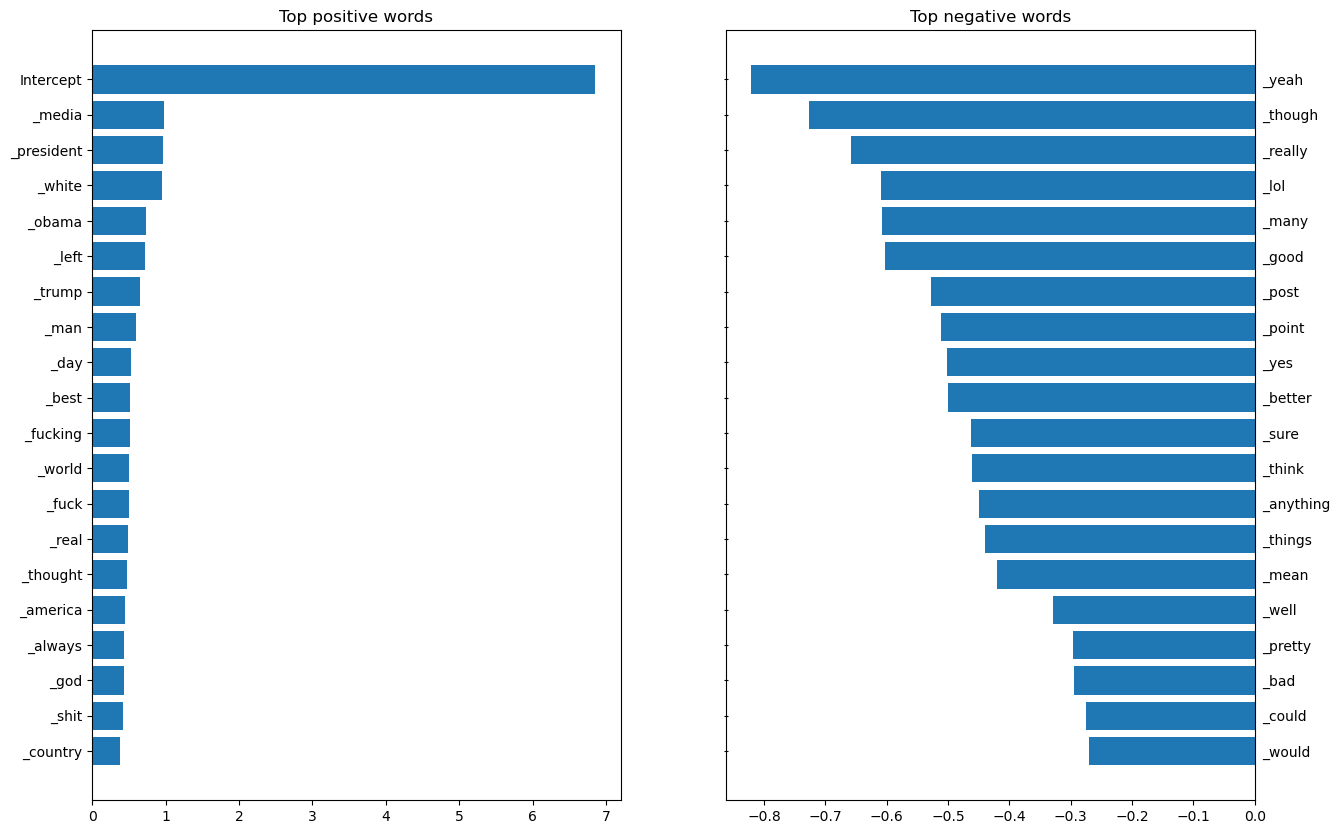

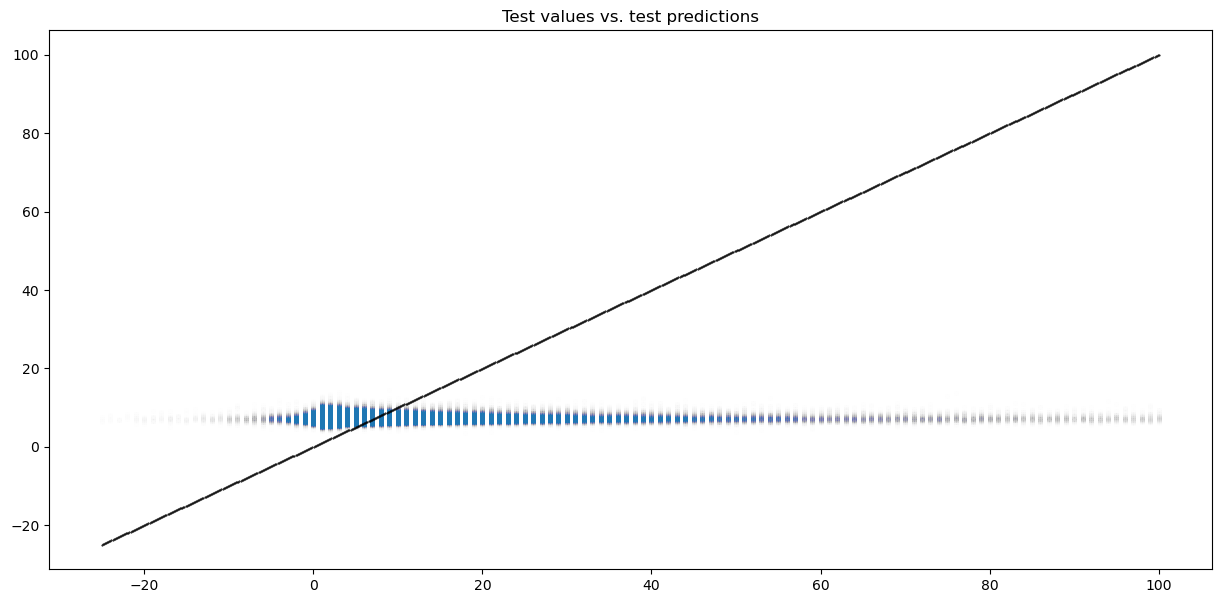

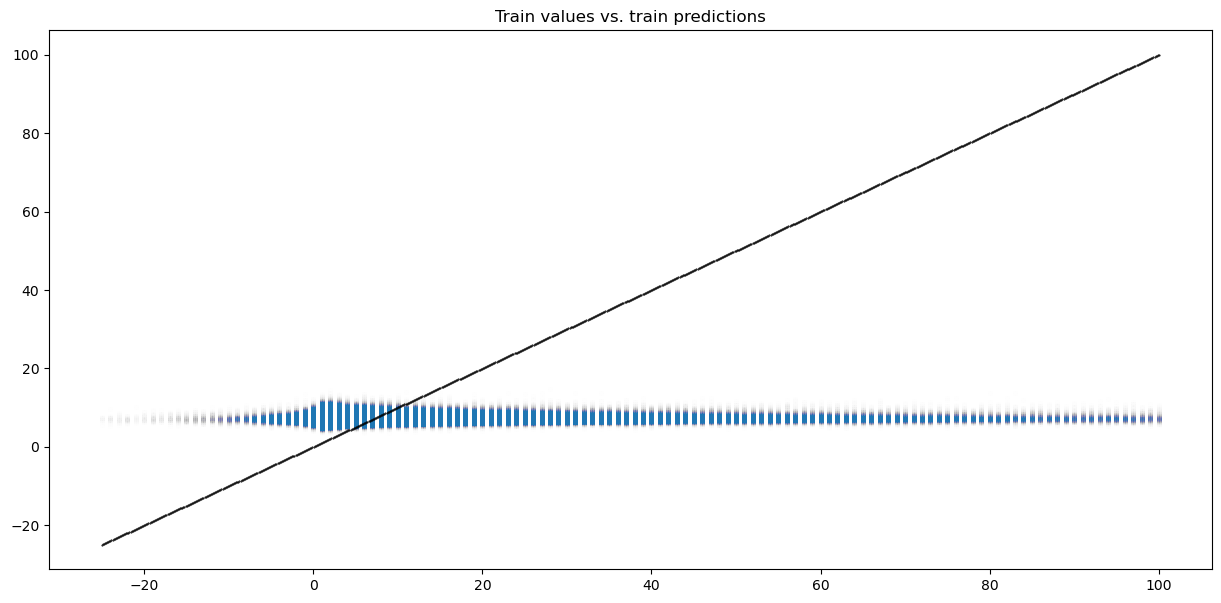

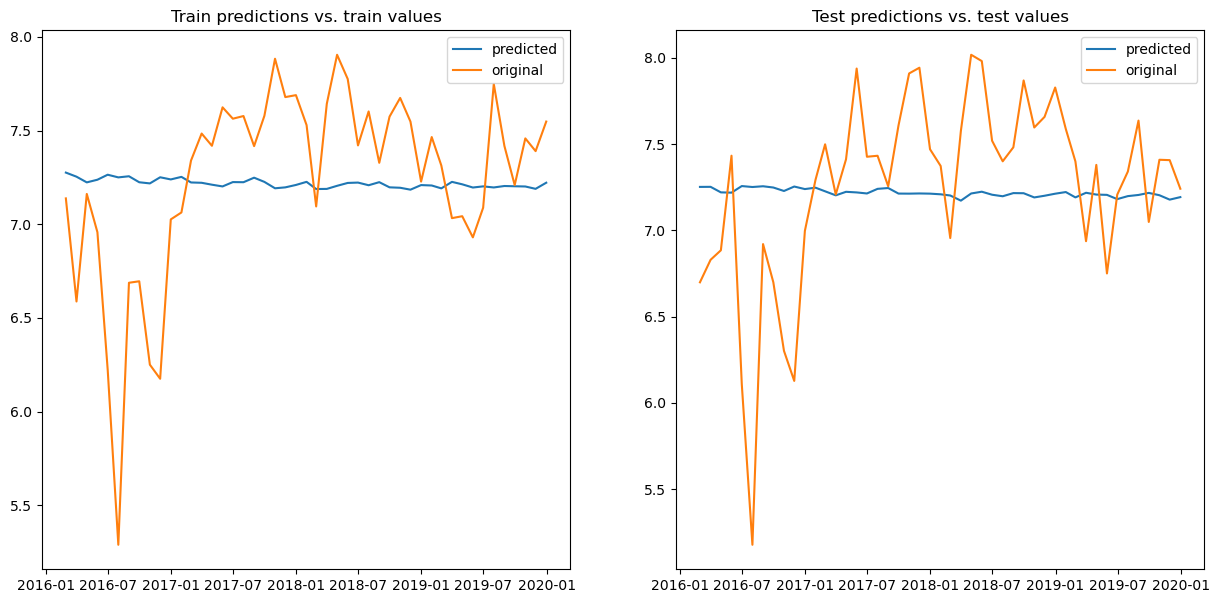

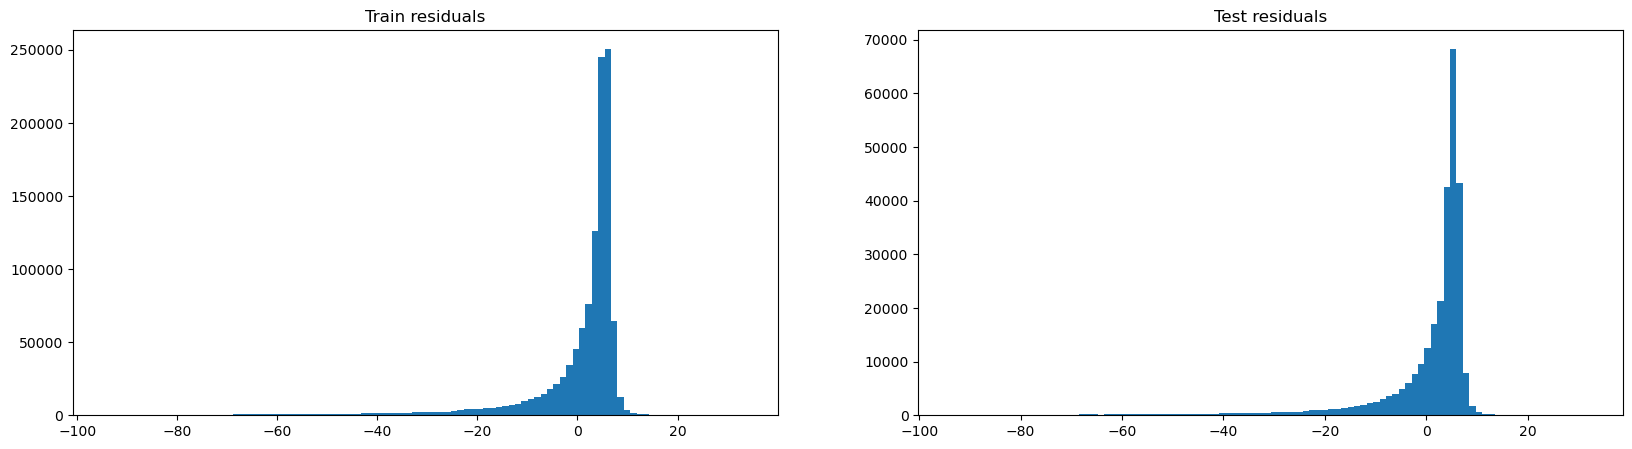

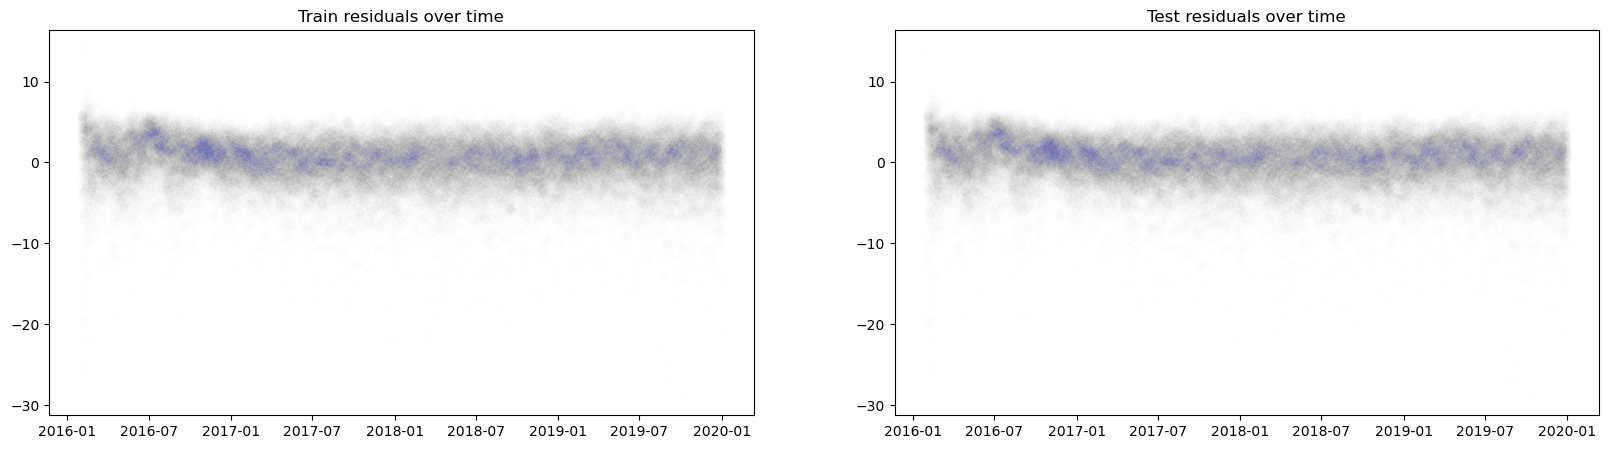

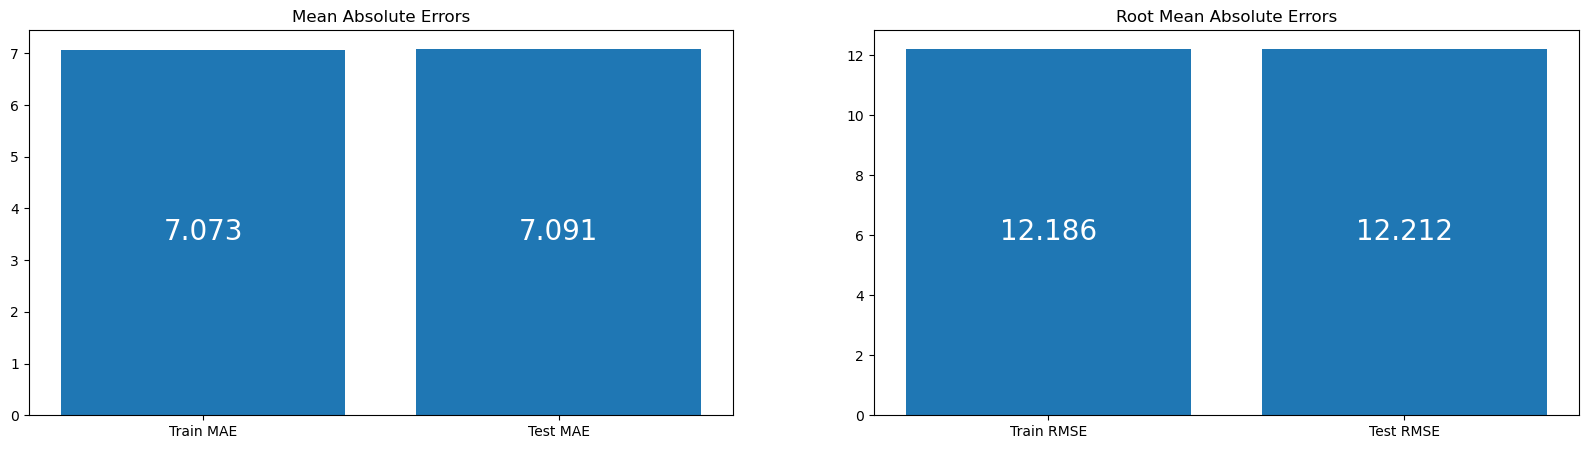

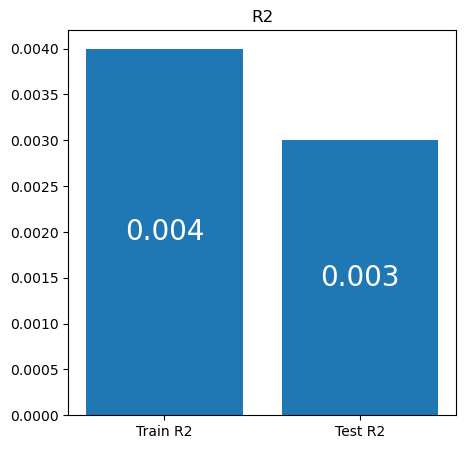

In [94]:
analyze_model(model4_results, line=True)

### Bigrams

In [95]:
X = bigram_features
y = scores[scores.index.isin(X.index)]
y.mean()

7.685962504584925

In [96]:
model5_results = linear_model(X, y)

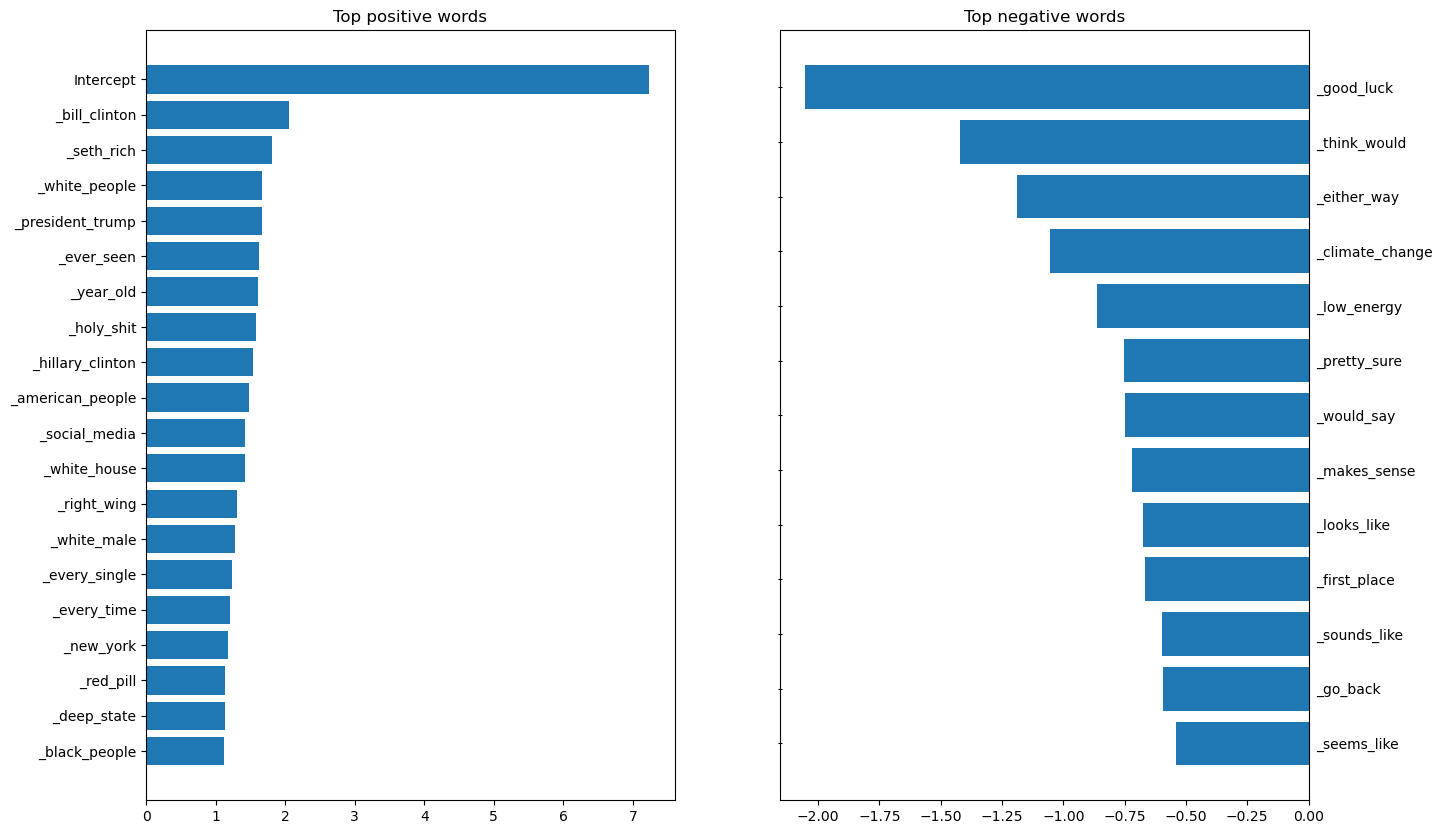

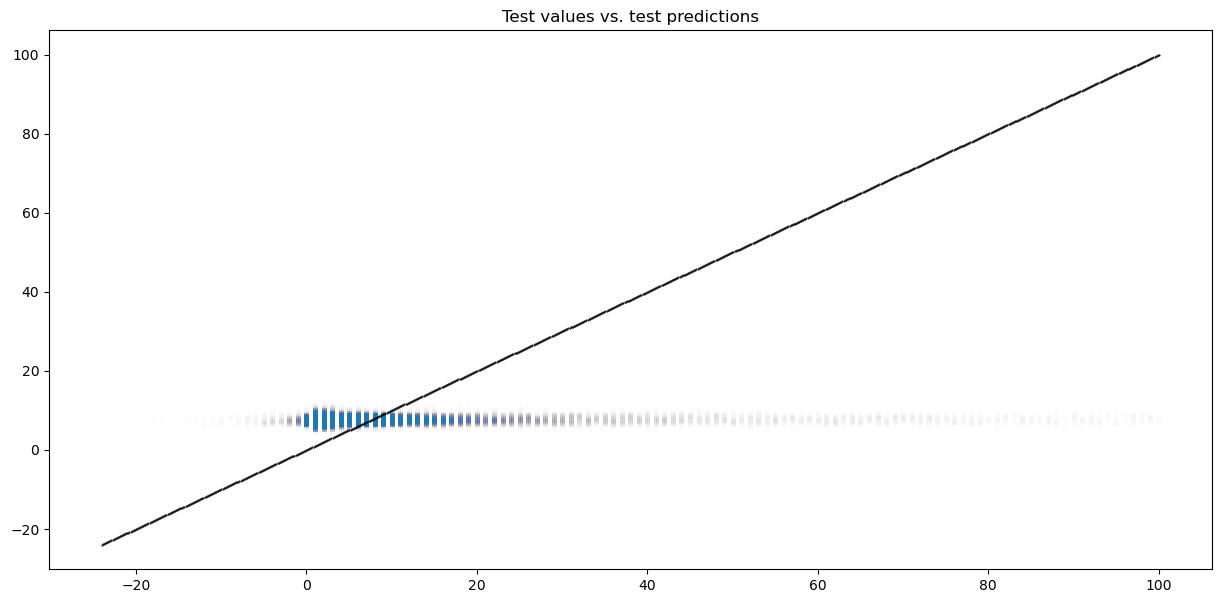

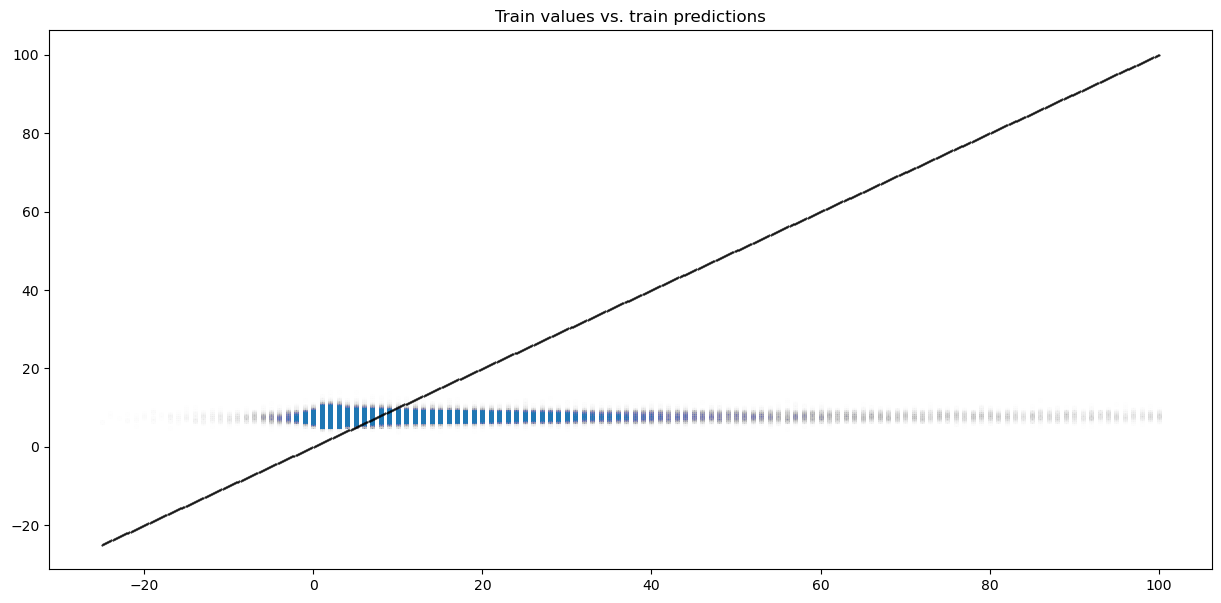

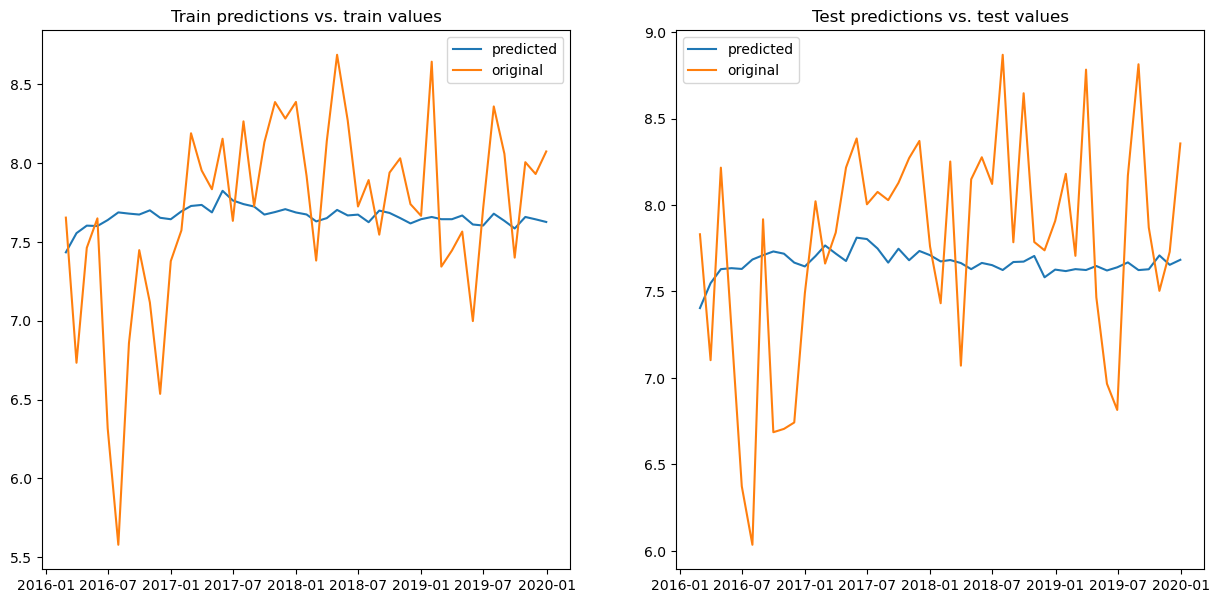

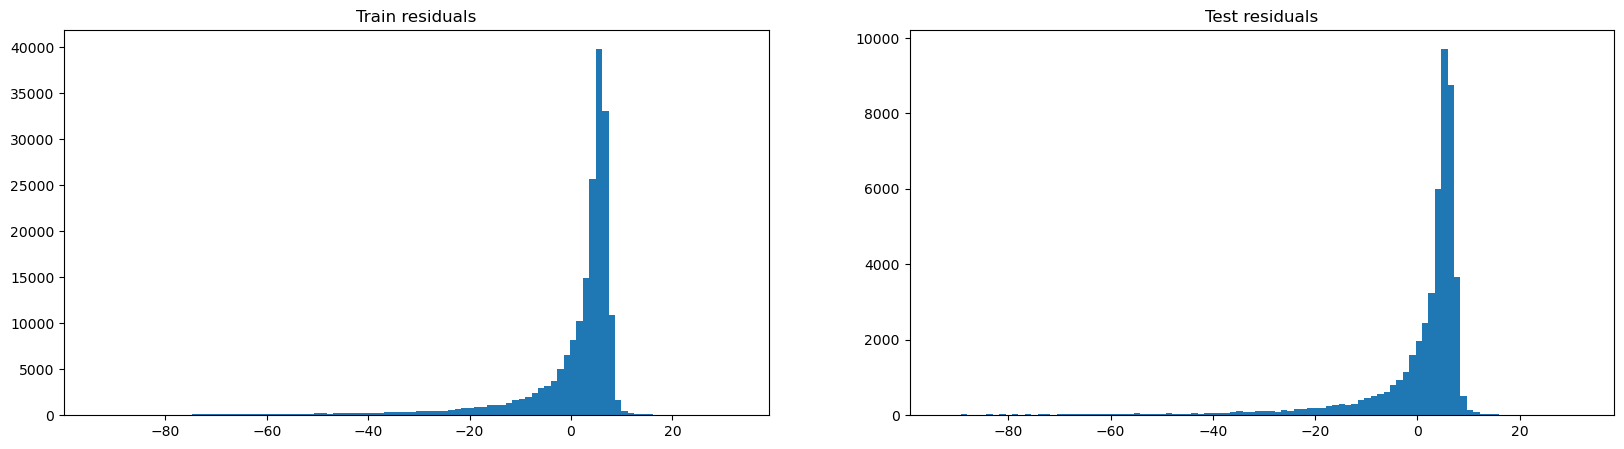

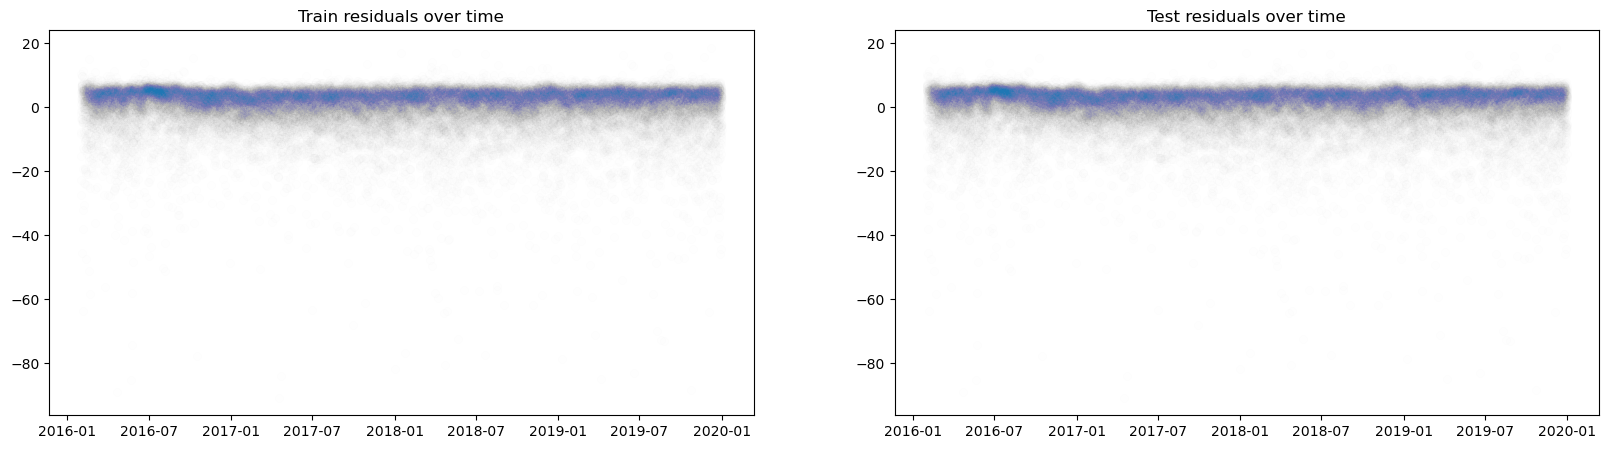

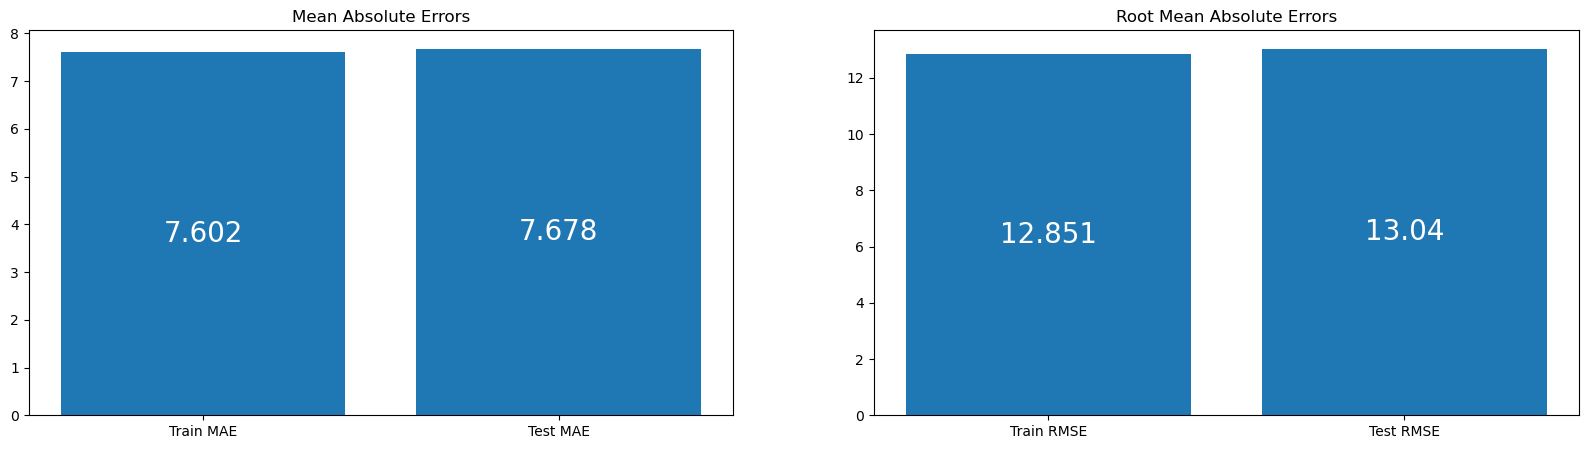

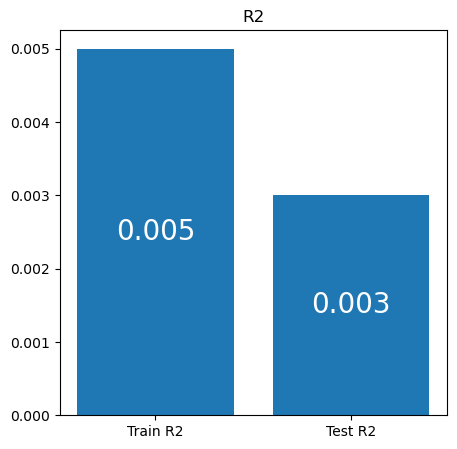

In [97]:
analyze_model(model5_results, line=True)

### Trigrams

In [98]:
X = trigram_features
y = scores[scores.index.isin(X.index)]
y.mean()

8.334464337279815

In [99]:
model6_results = linear_model(X, y)

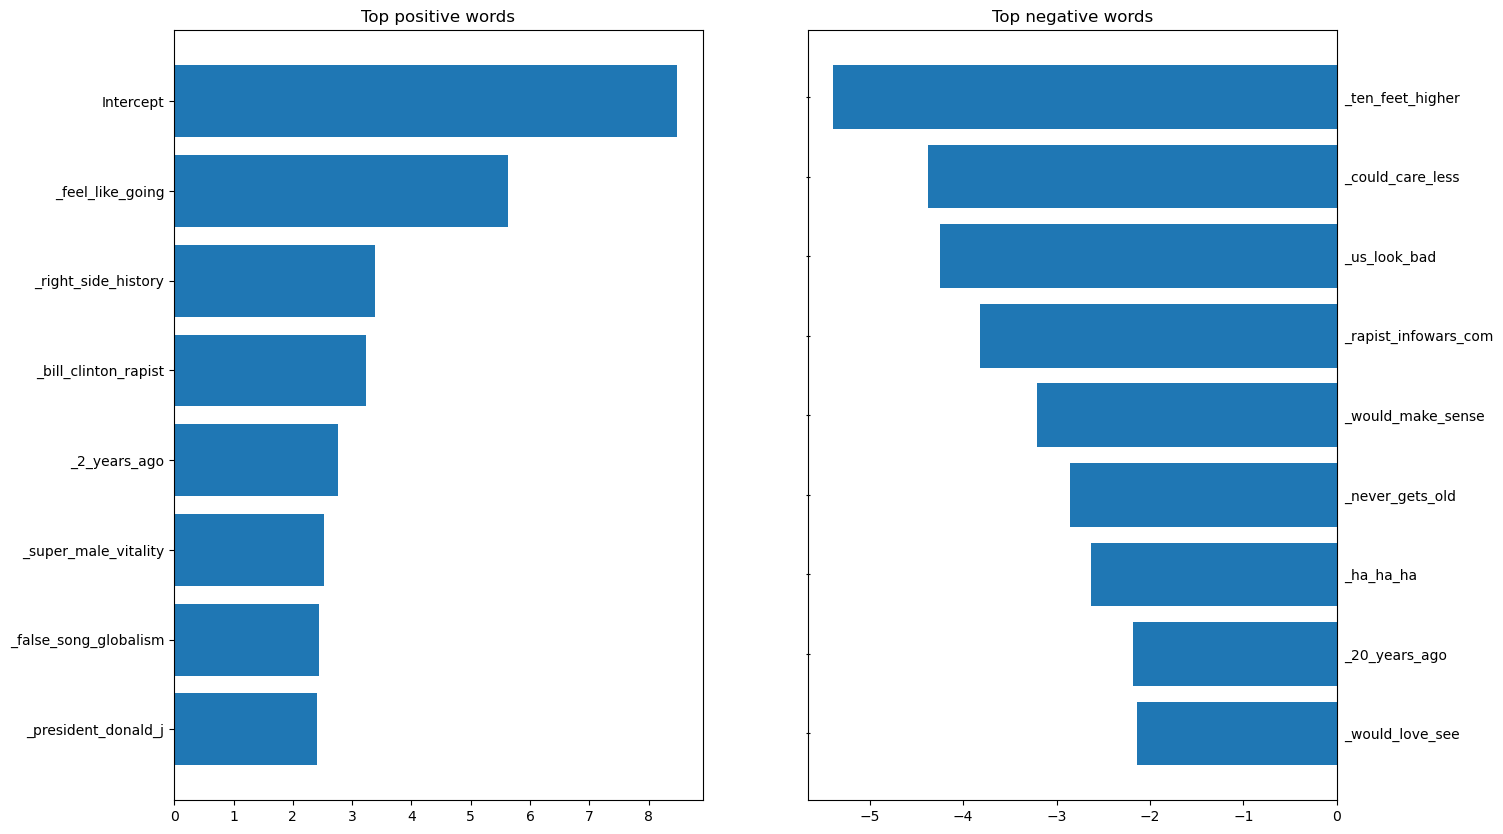

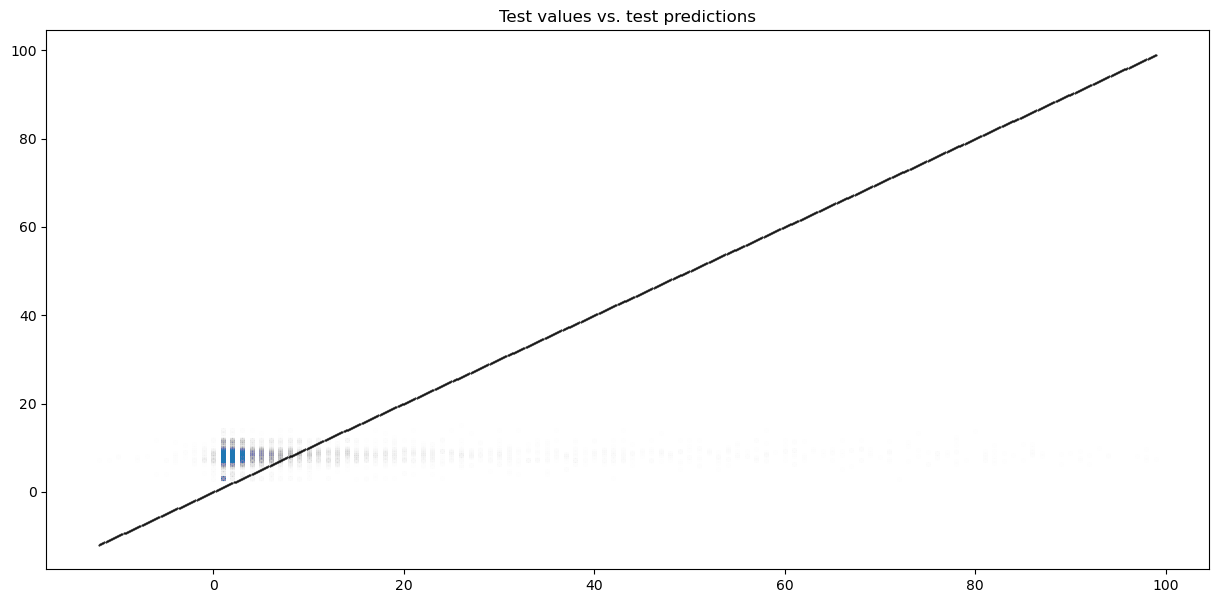

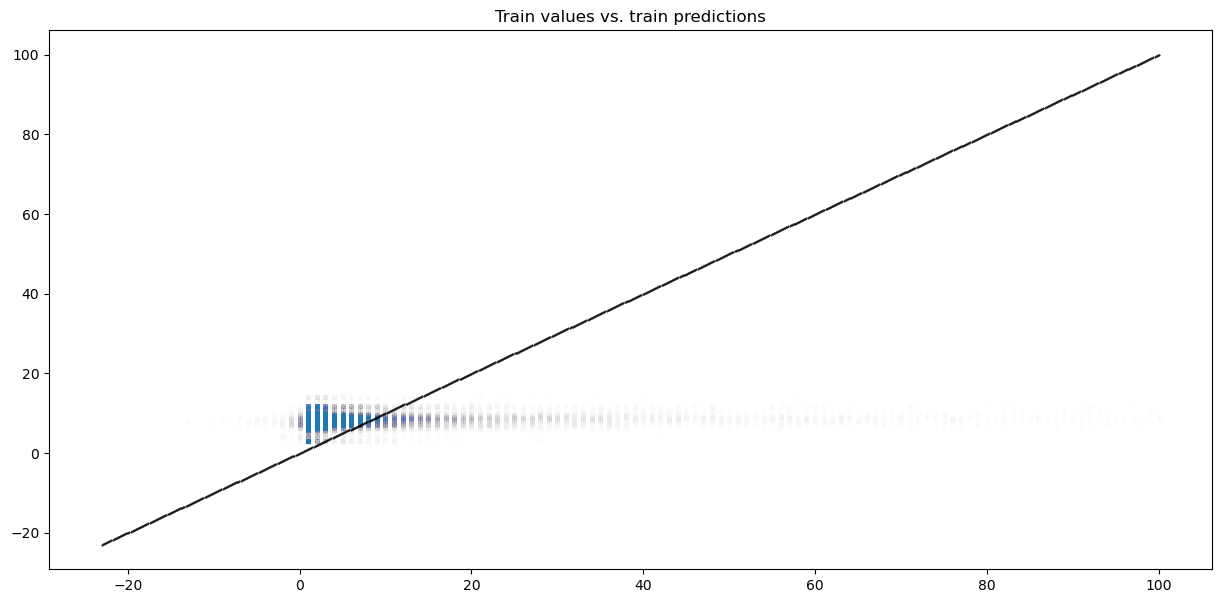

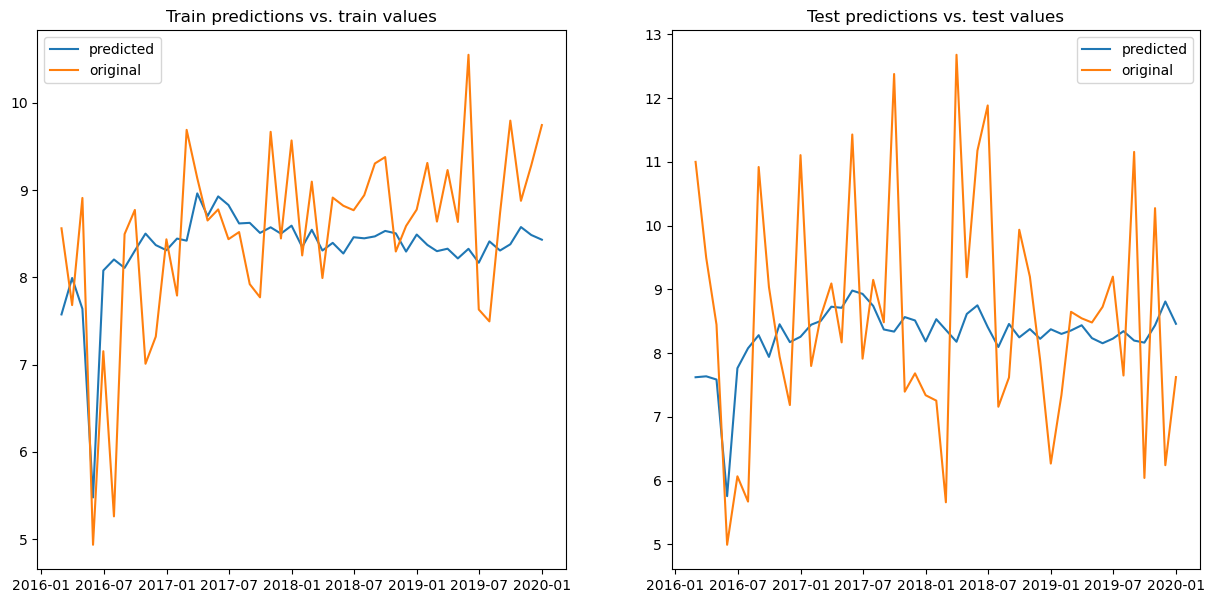

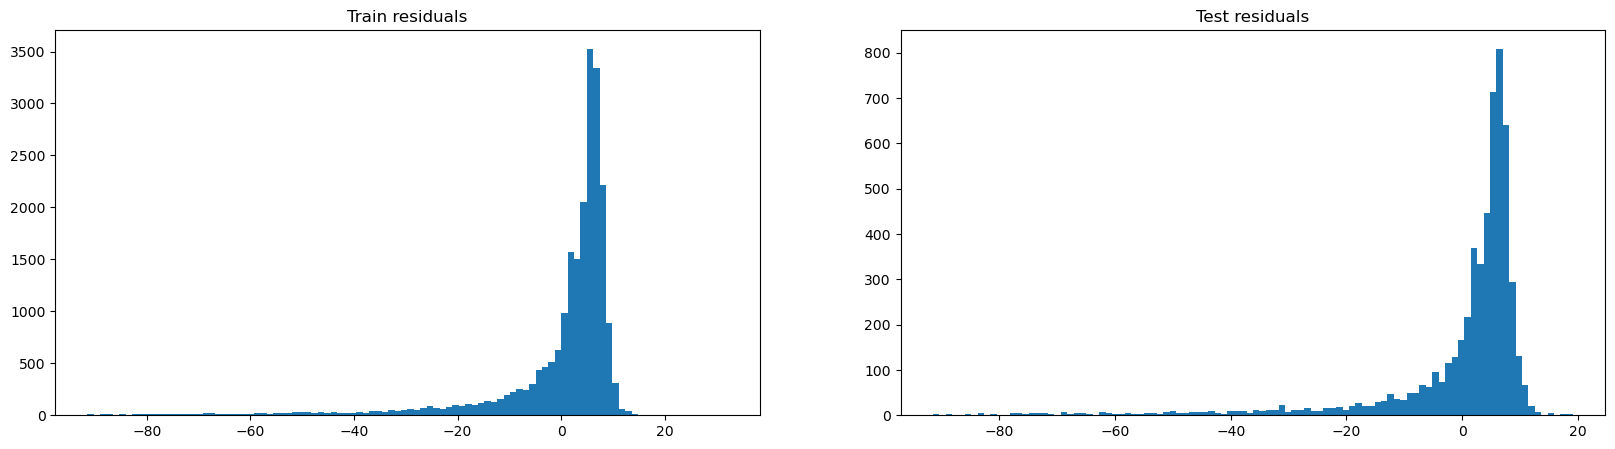

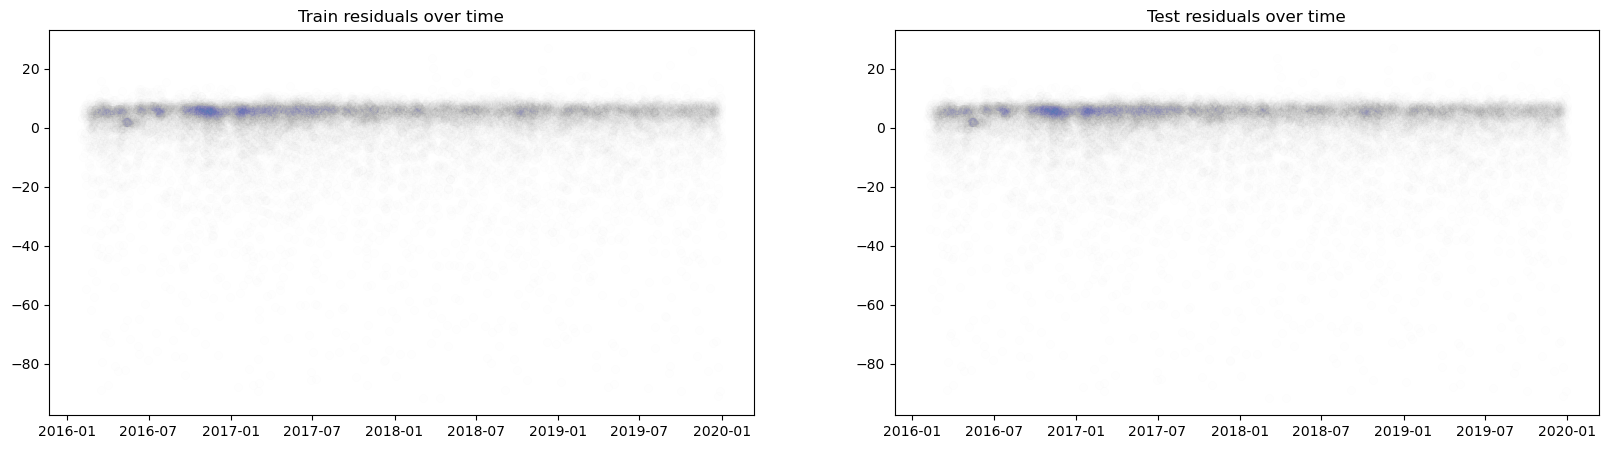

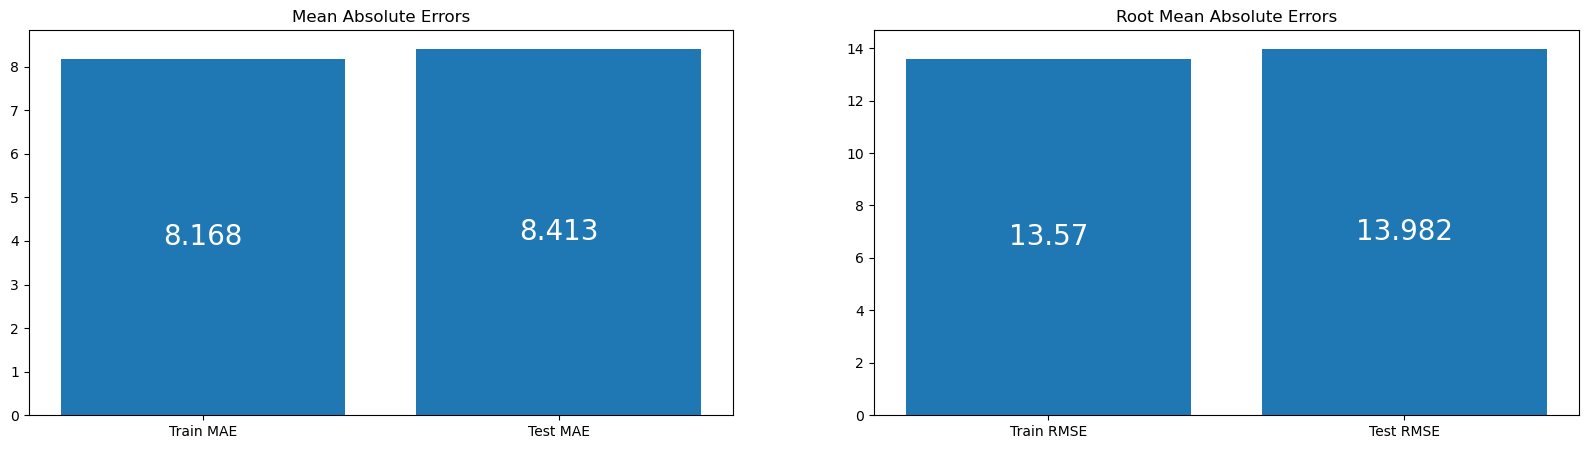

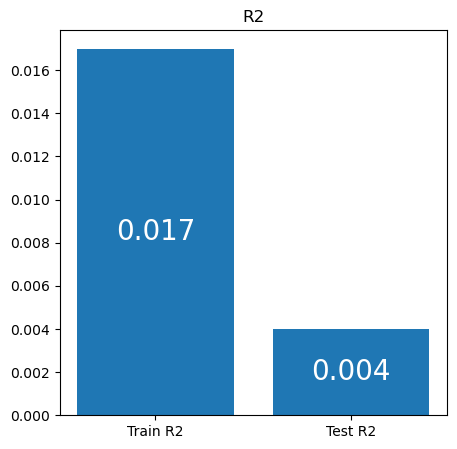

In [100]:
analyze_model(model6_results, line=True)

# Base Model: Linear Regression, VADER as target

### Unigrams

In [101]:
X = unigram_features
y = sentiment[sentiment.index.isin(X.index)]

In [102]:
model1_results = linear_model(X, y)

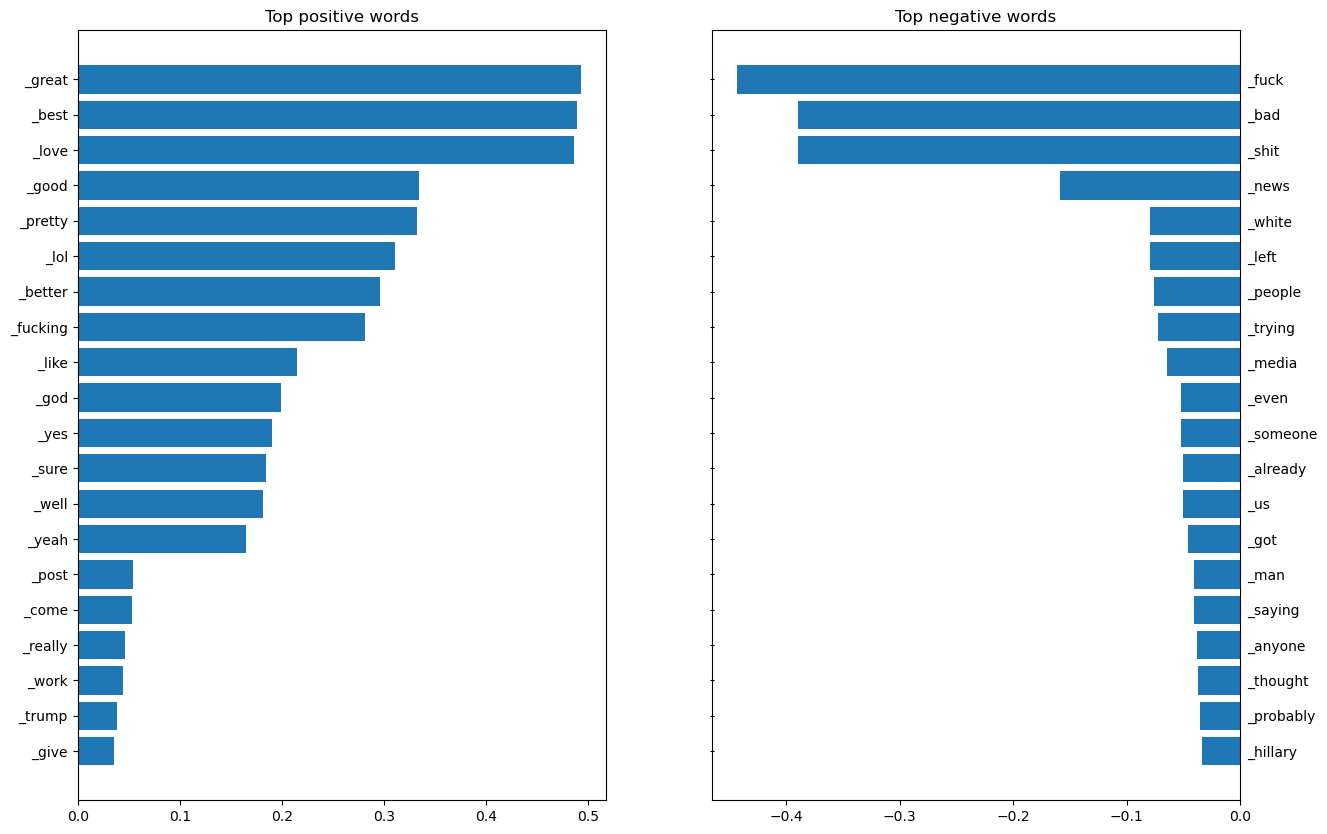

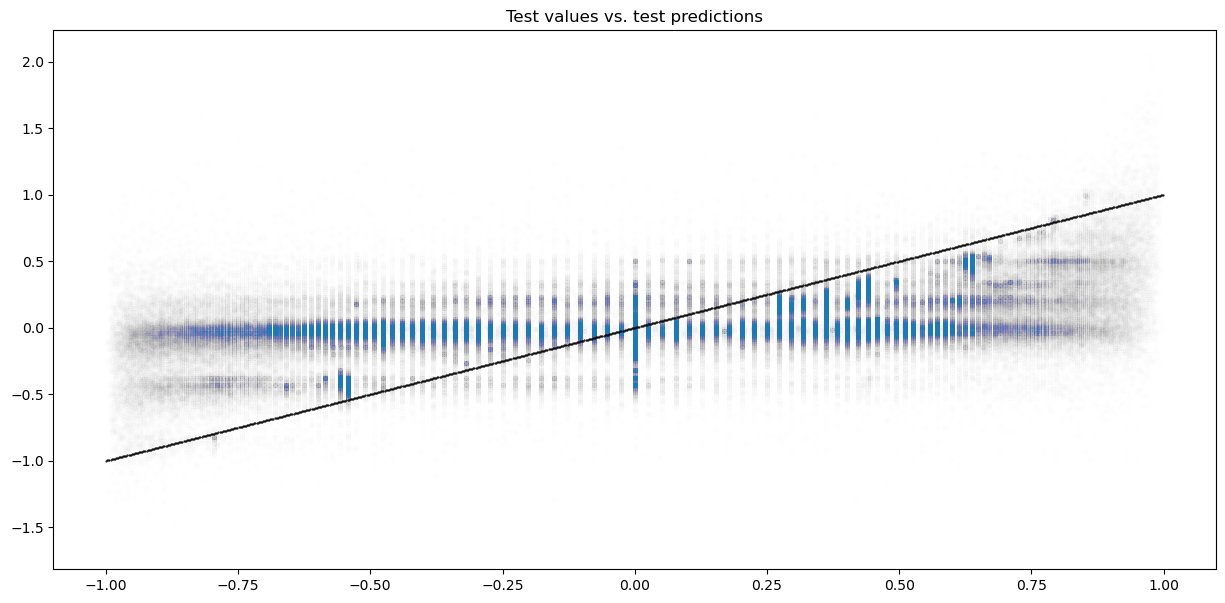

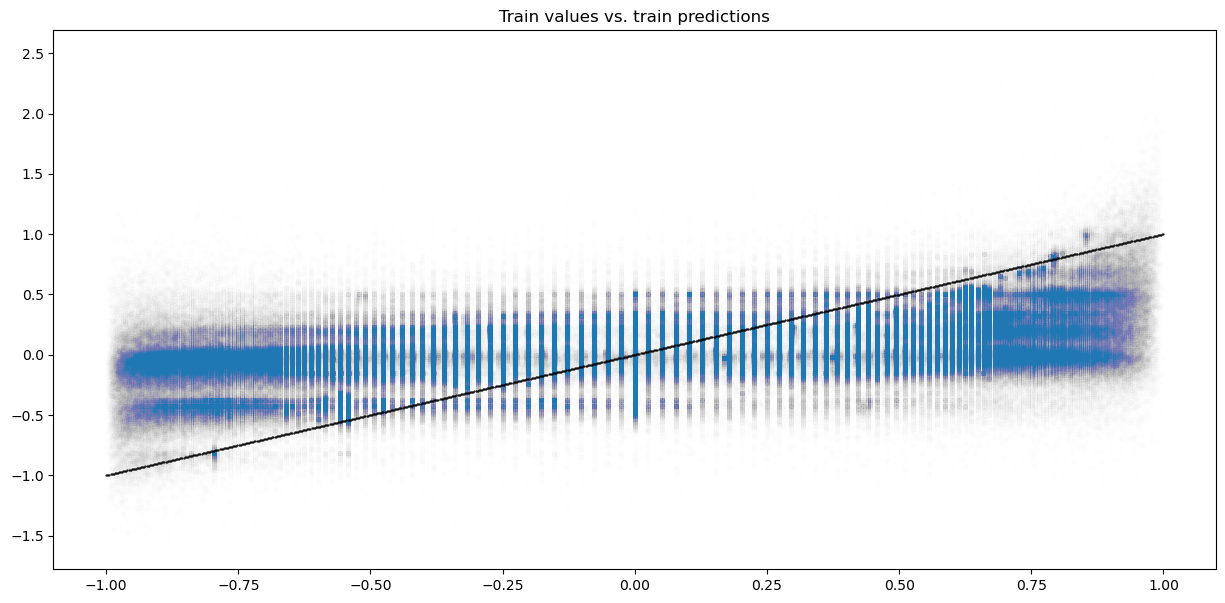

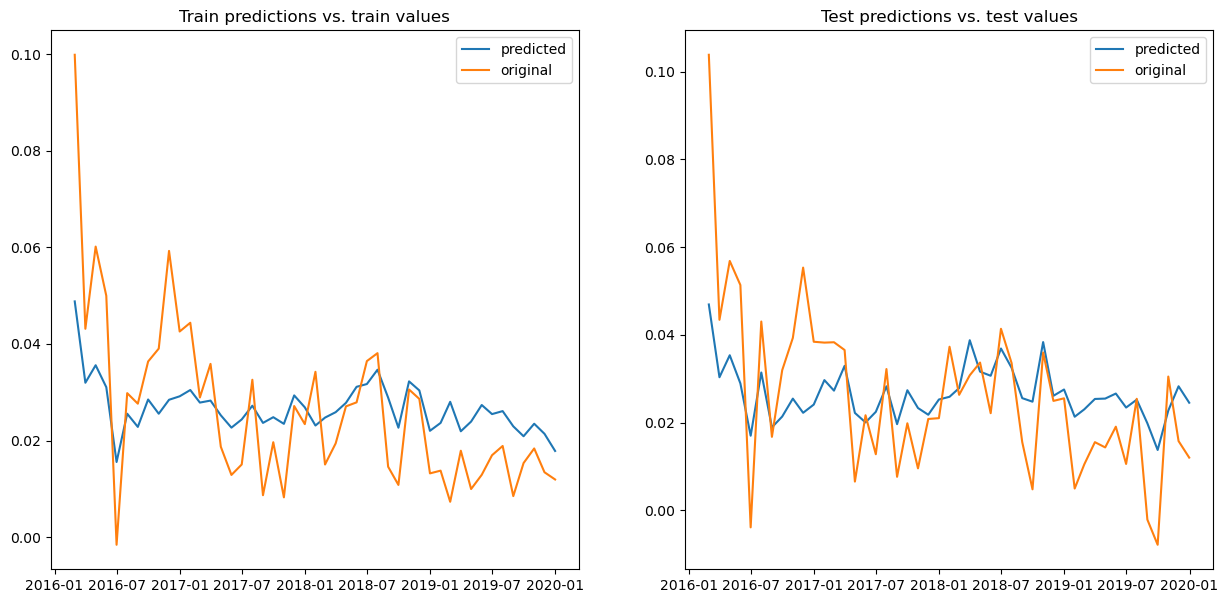

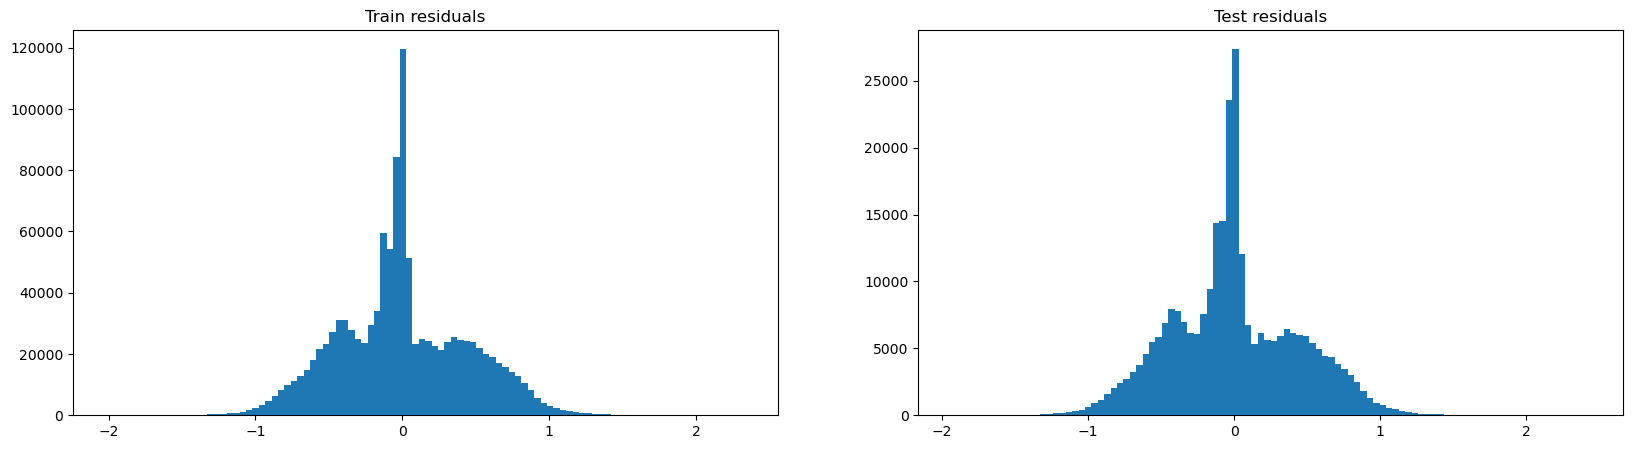

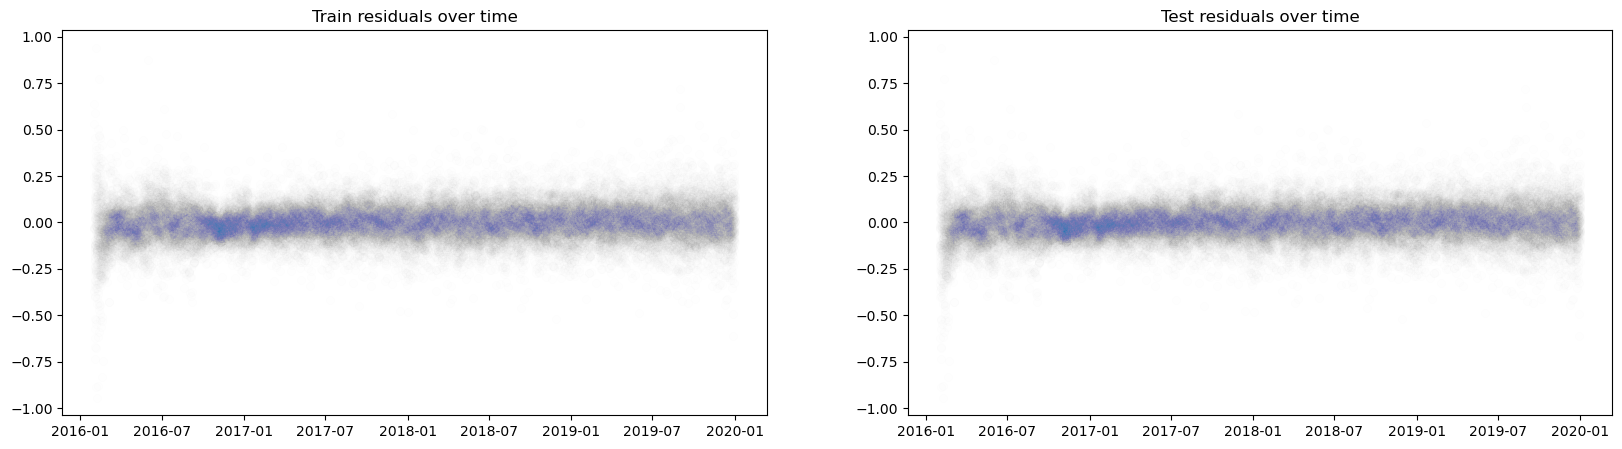

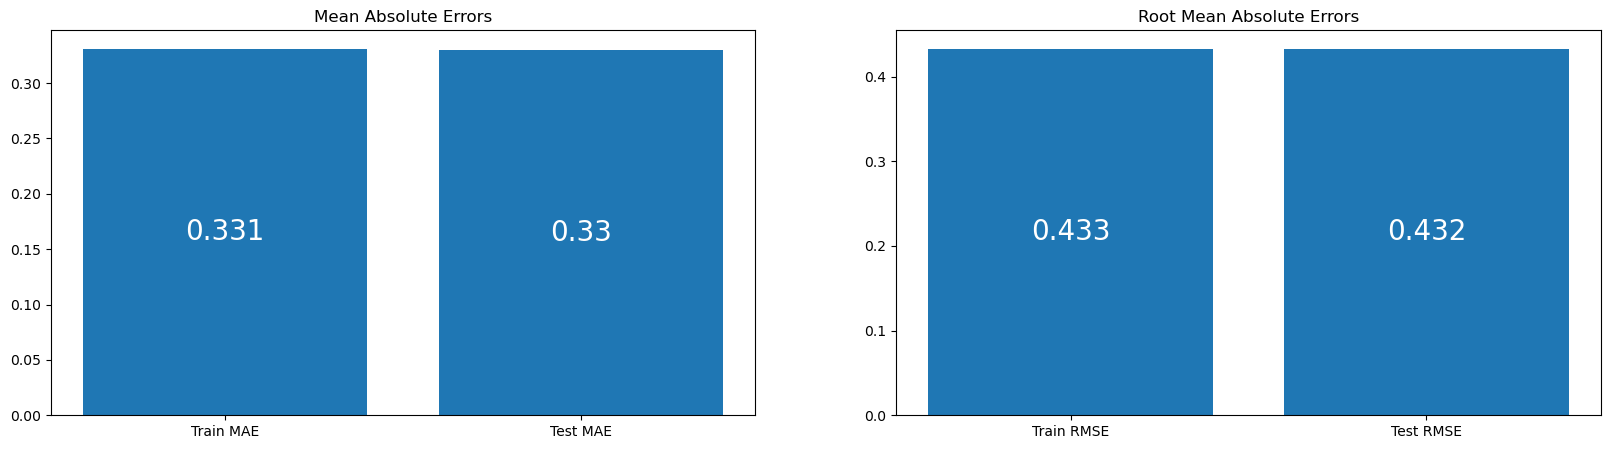

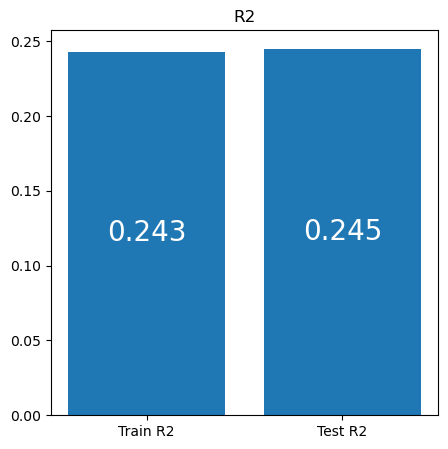

In [103]:
analyze_model(model1_results)

### Bigrams

In [104]:
X = bigram_features
y = sentiment[sentiment.index.isin(X.index)]
model2_results = linear_model(X, y)

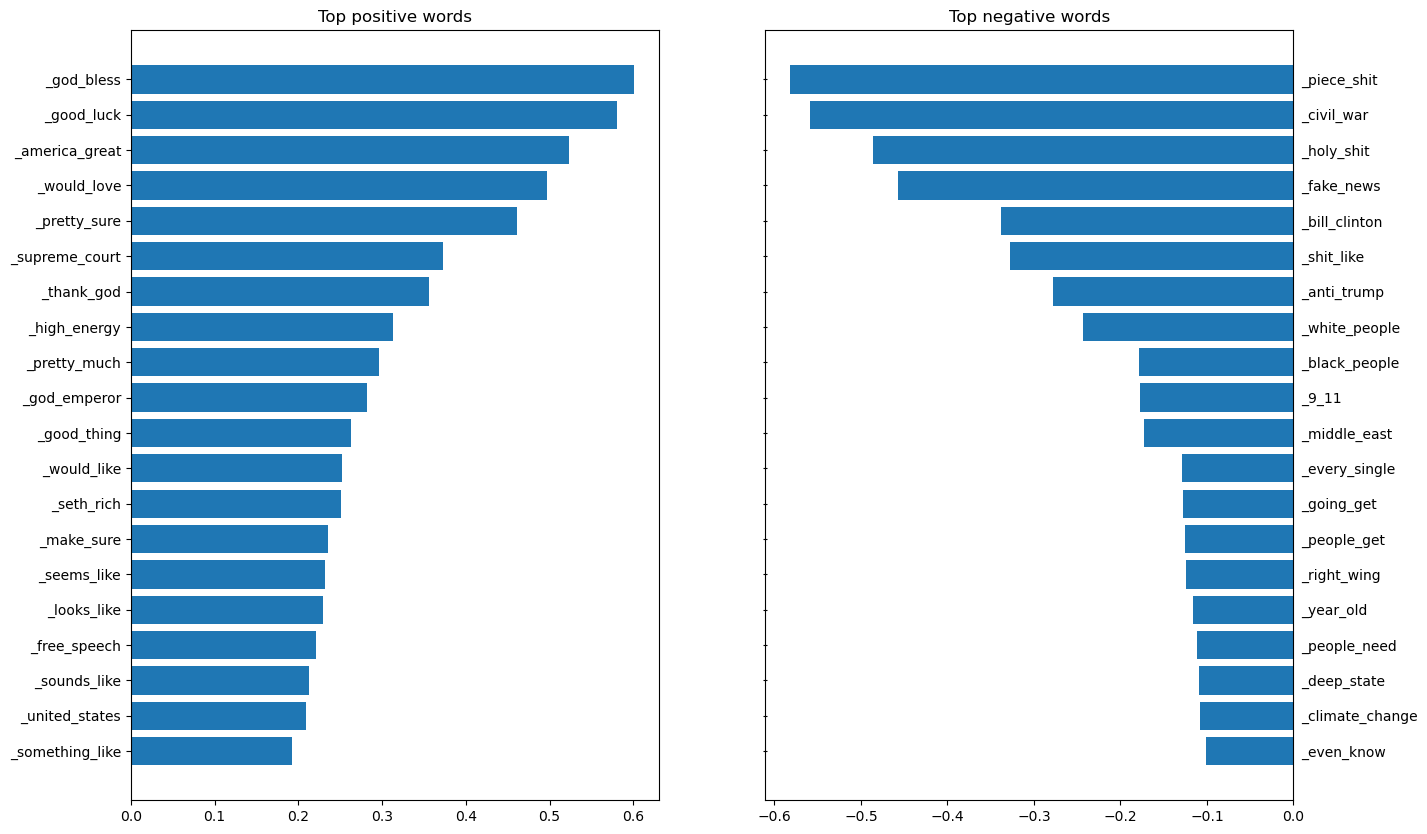

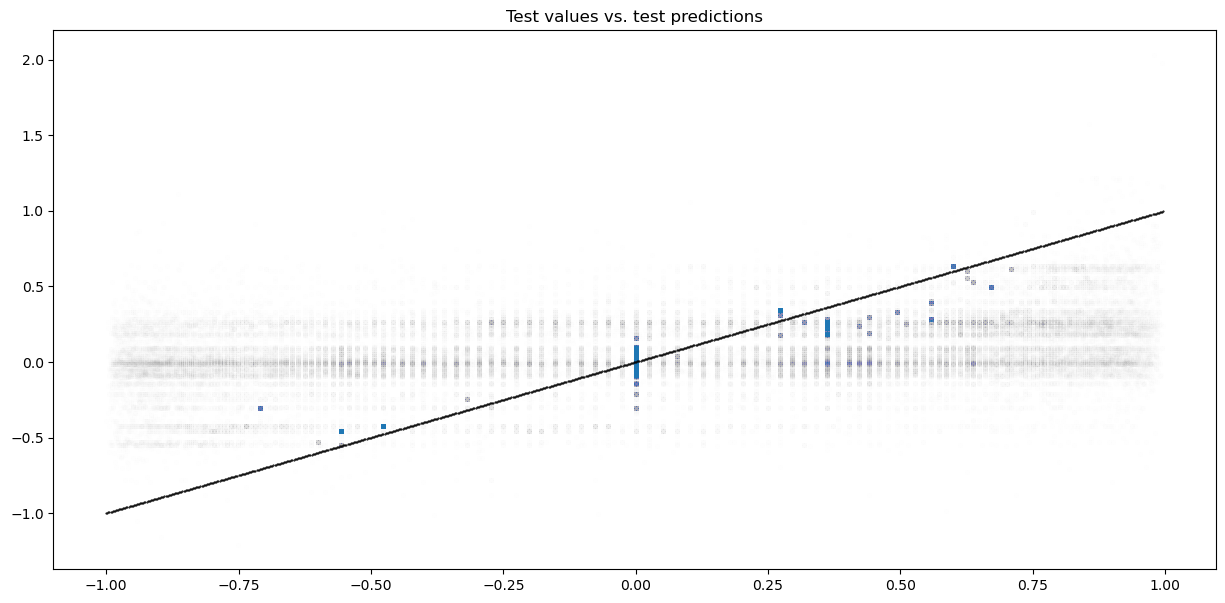

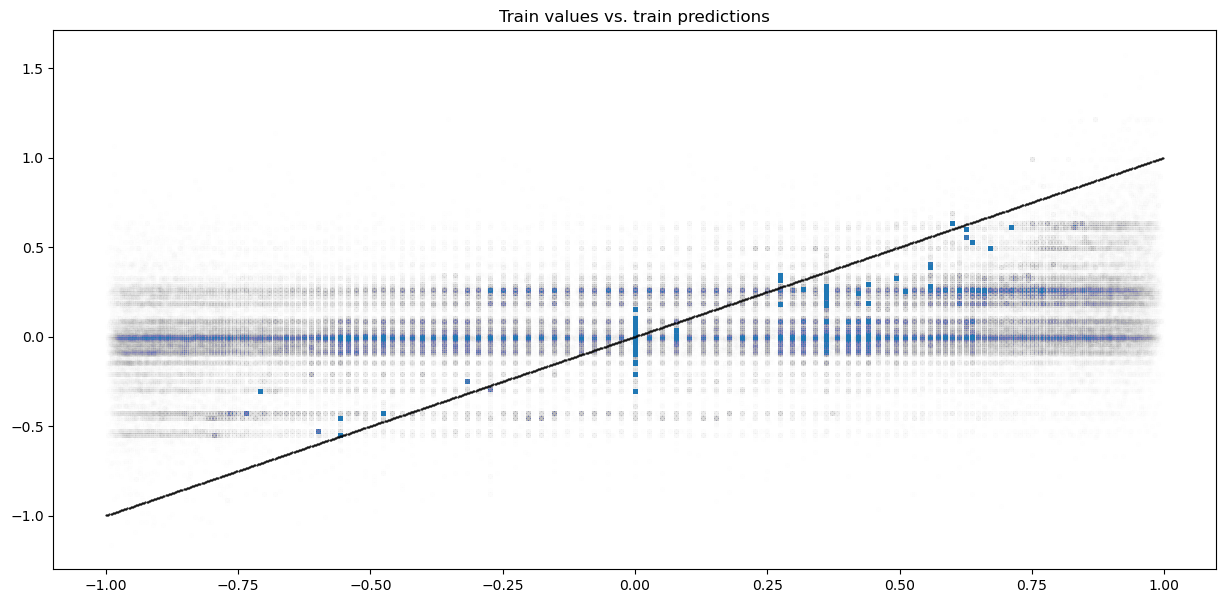

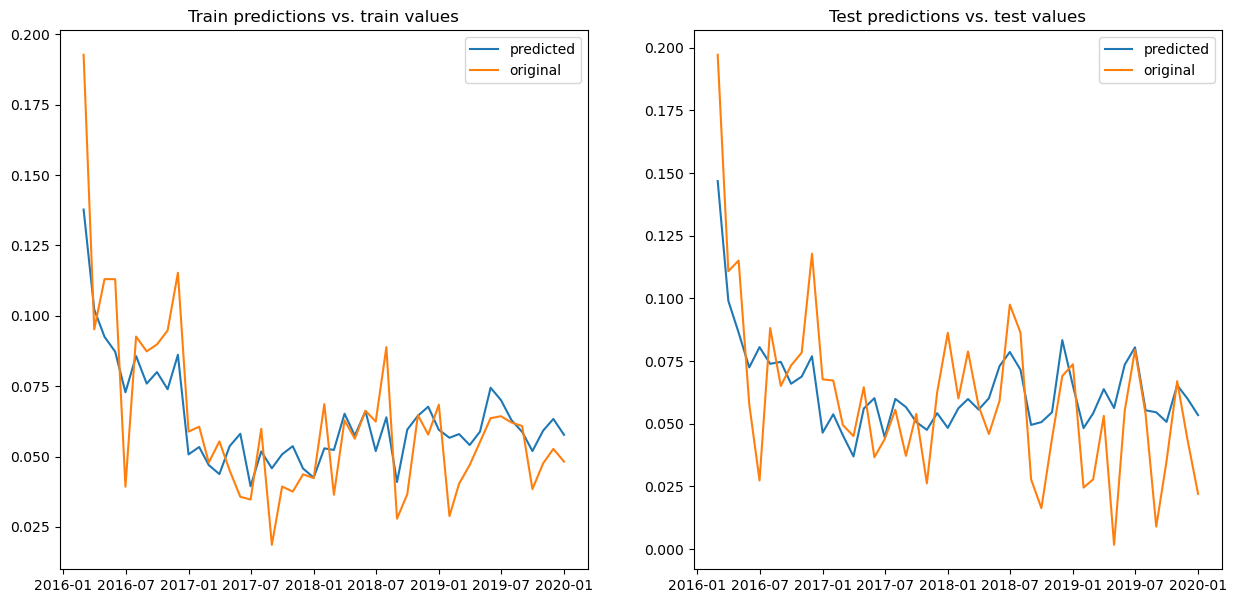

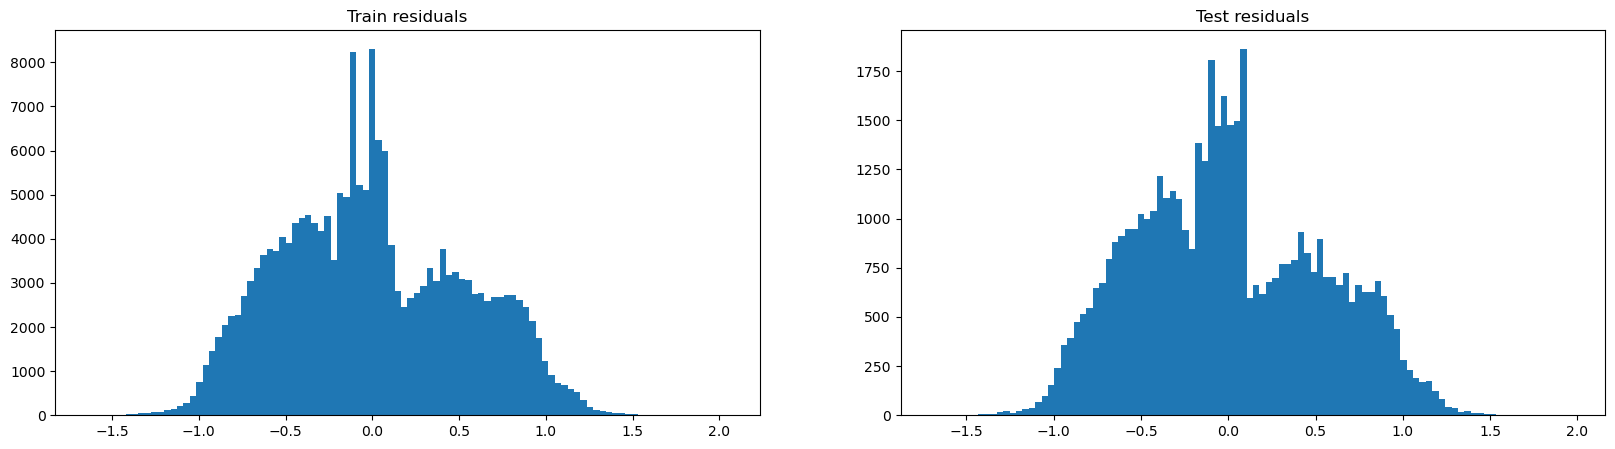

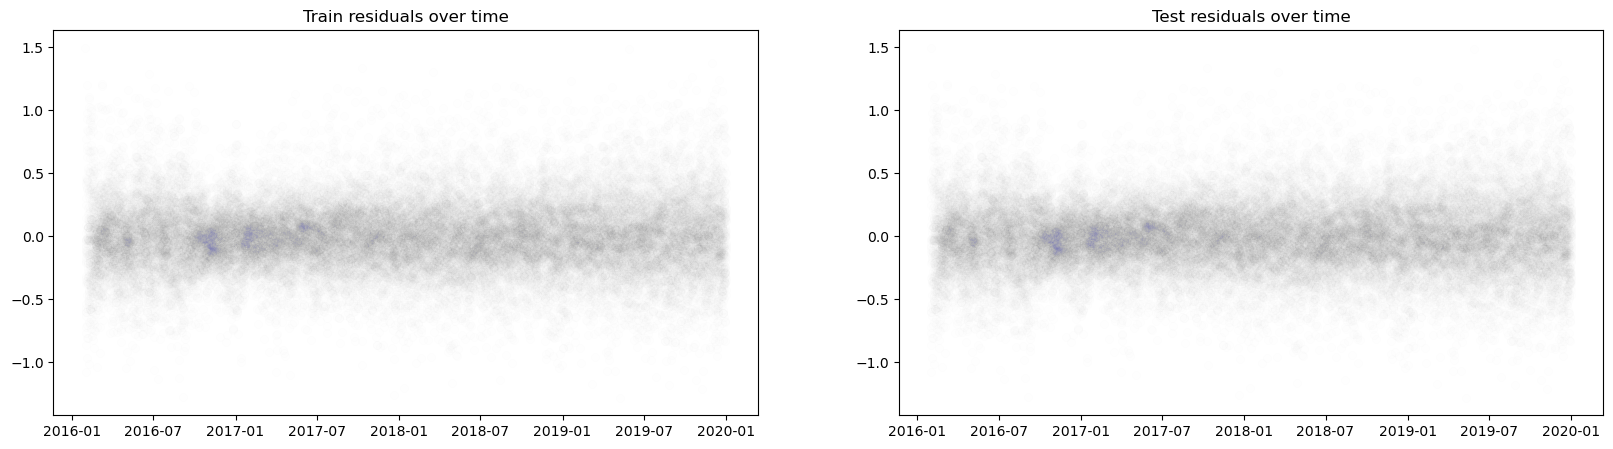

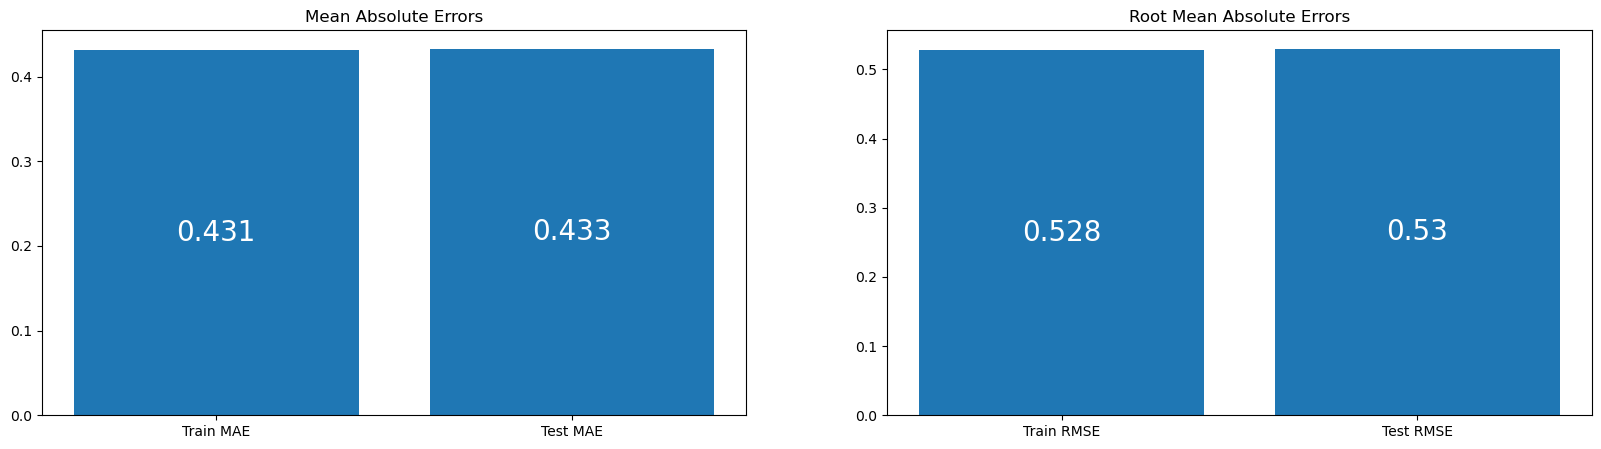

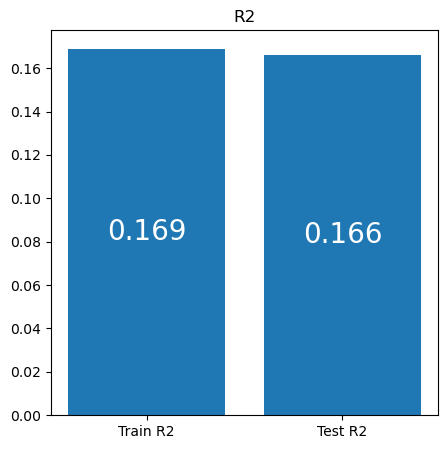

In [105]:
analyze_model(model2_results)

### Trigrams

In [106]:
X = trigram_features
y = sentiment[sentiment.index.isin(X.index)]
model3_results = linear_model(X, y)

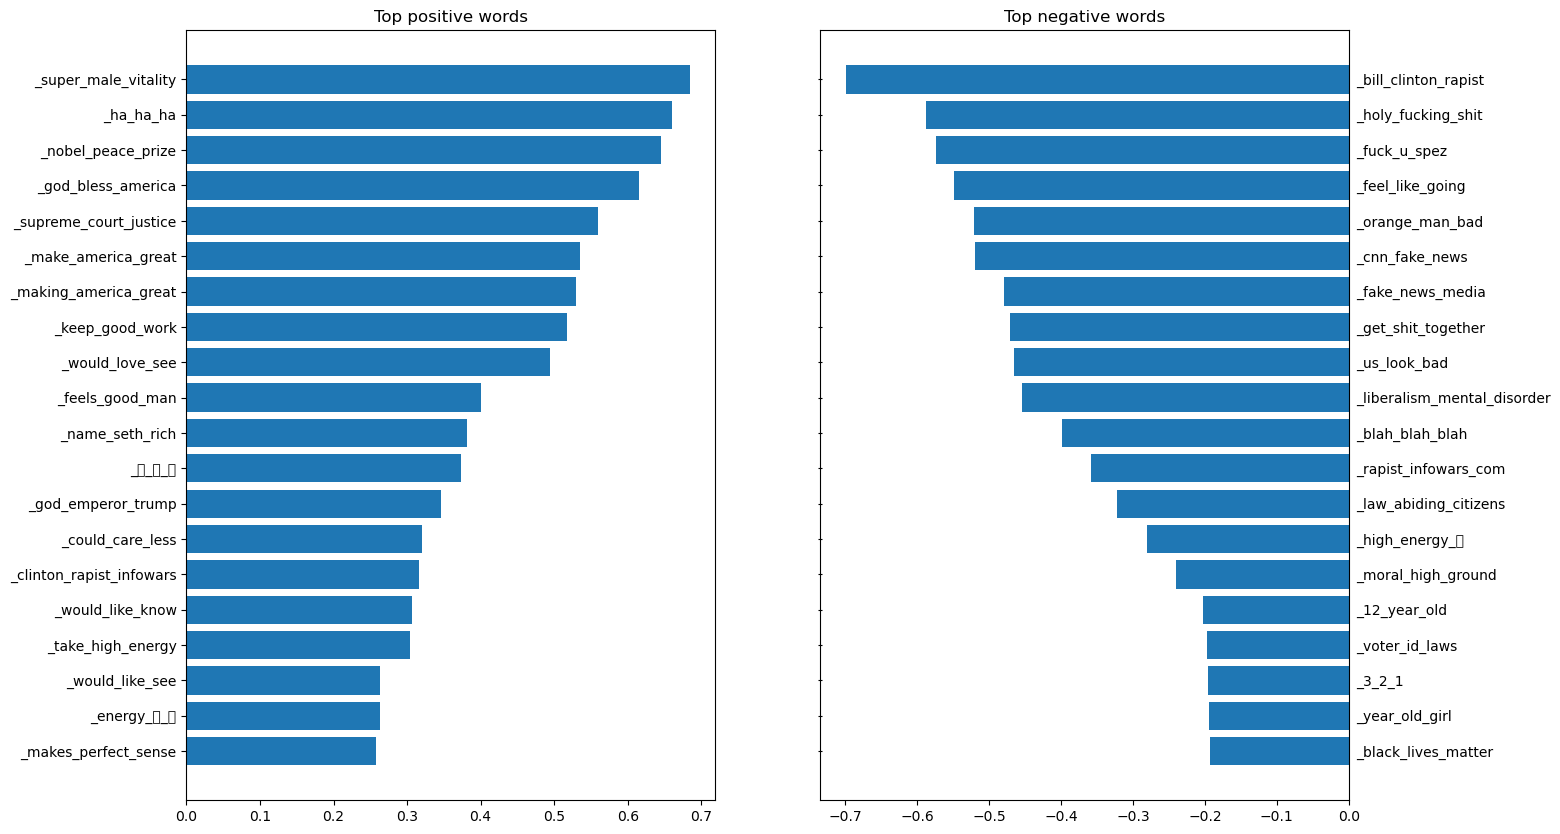

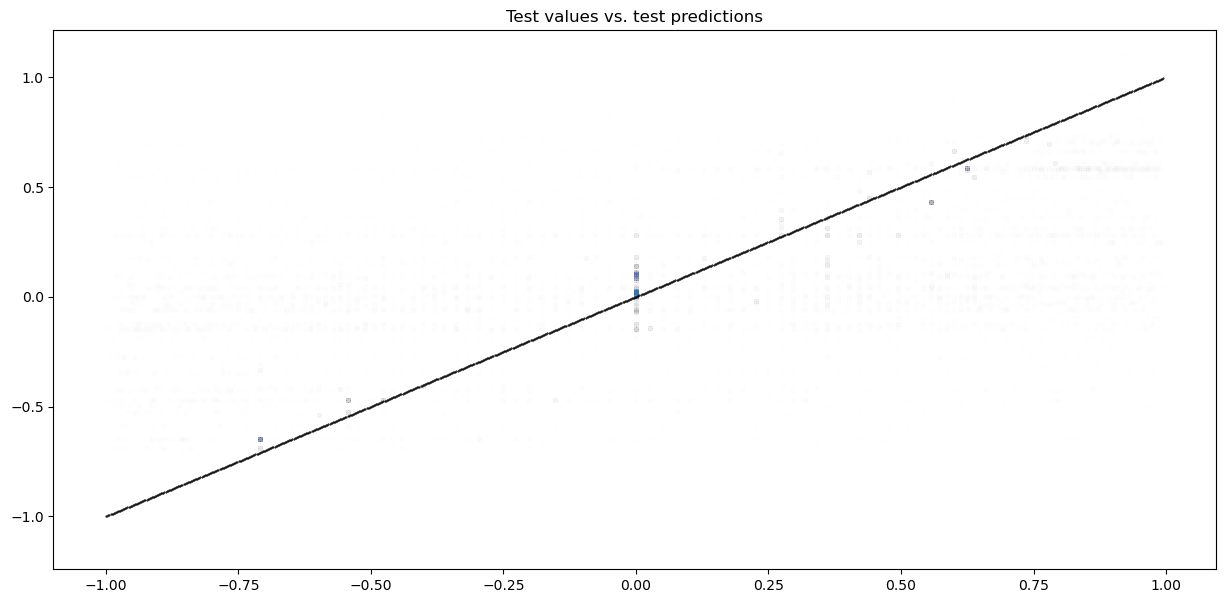

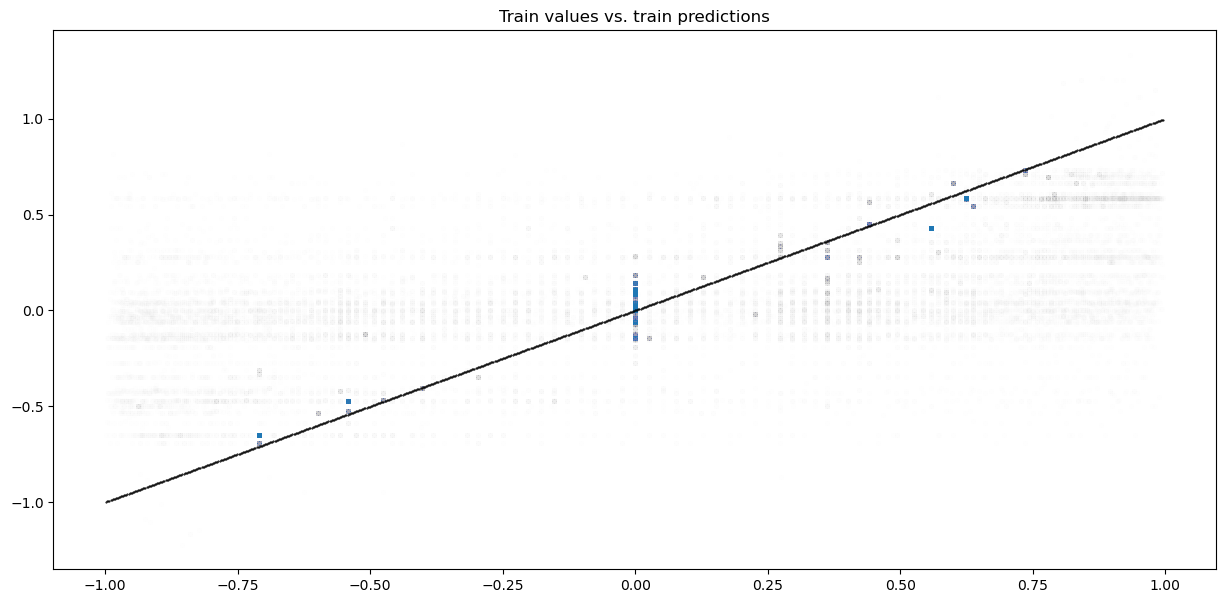

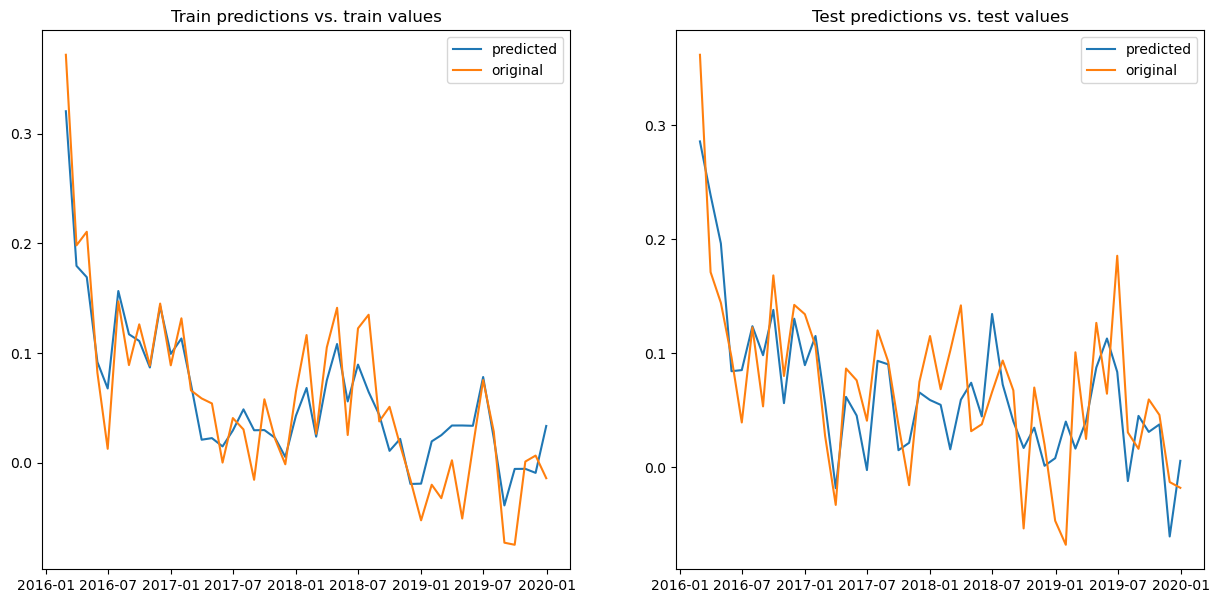

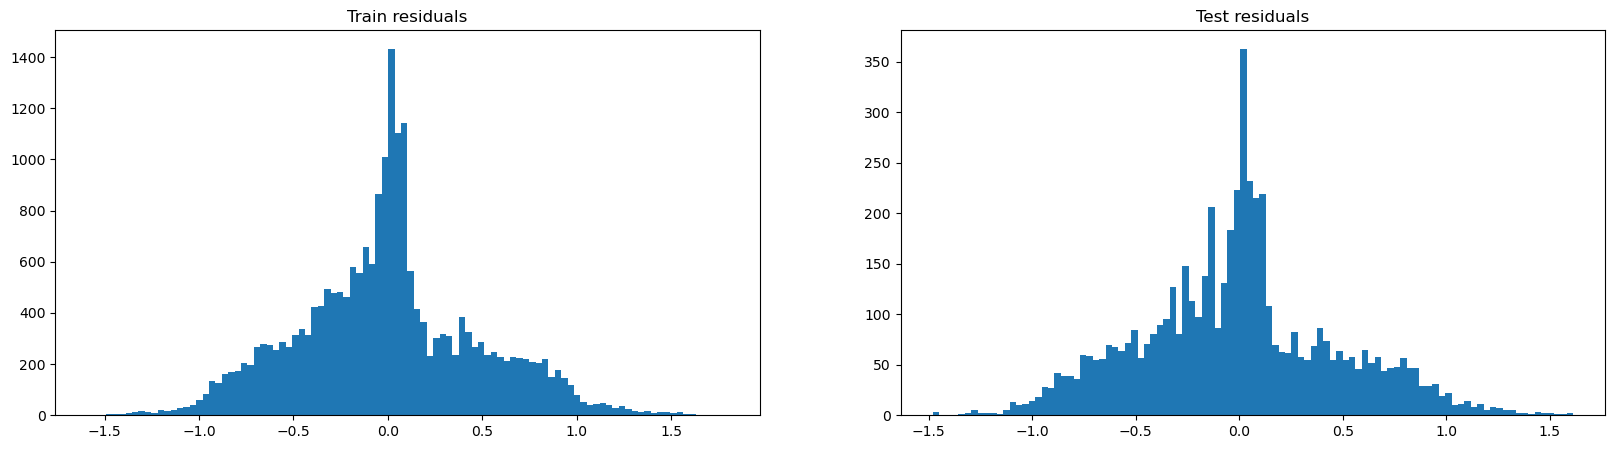

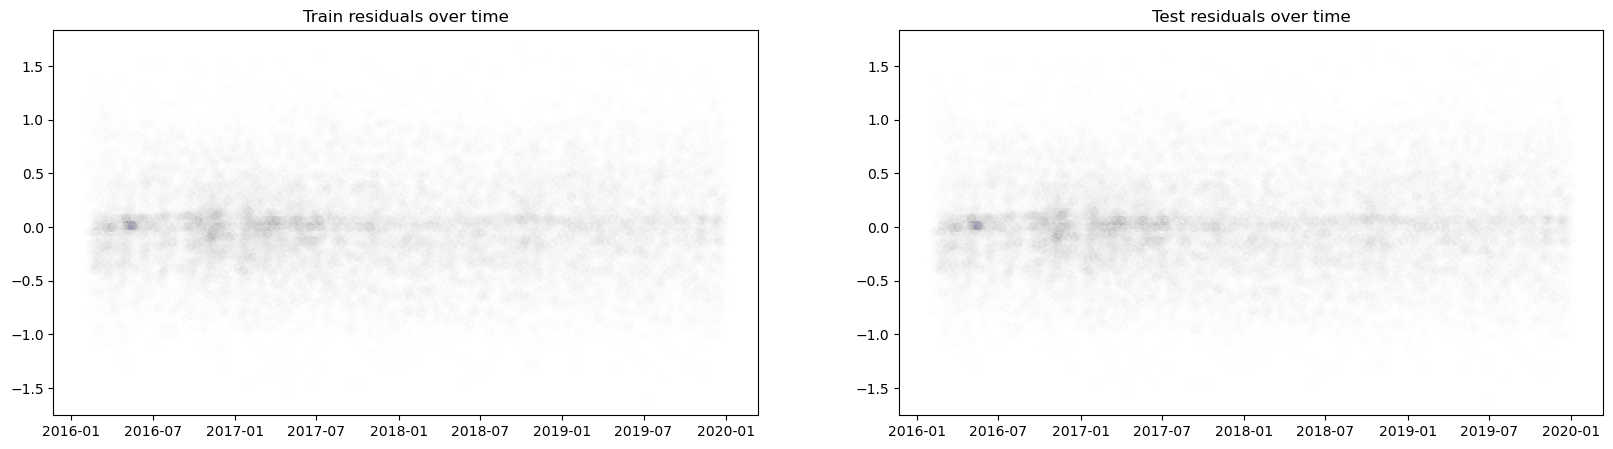

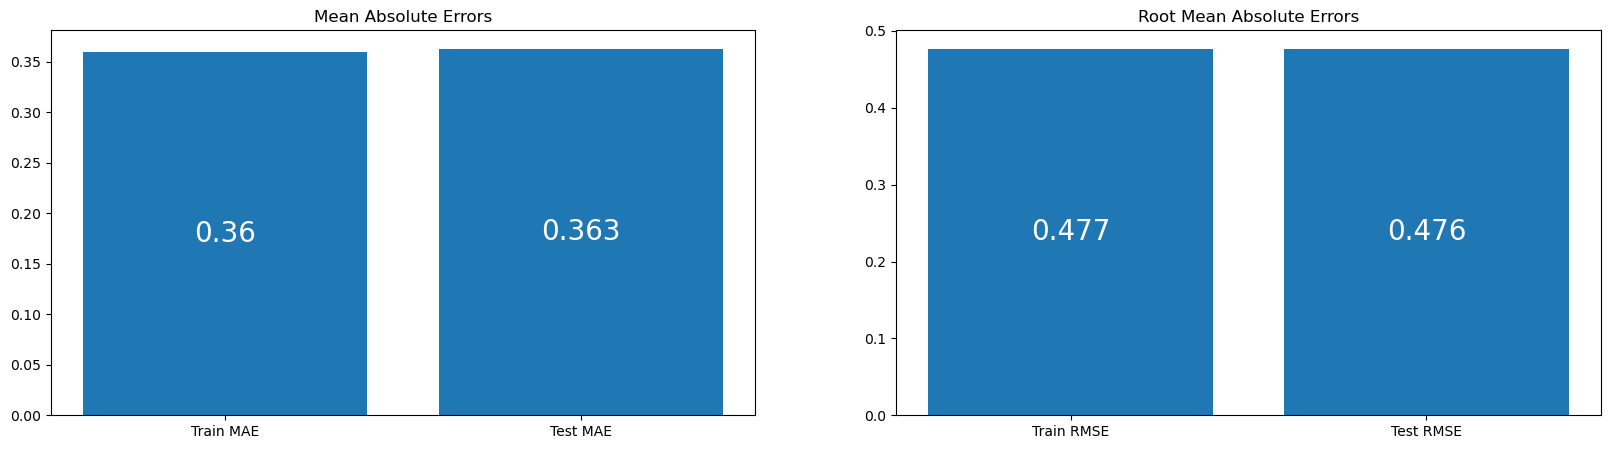

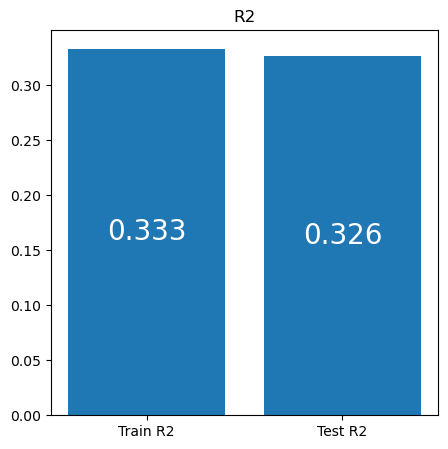

In [107]:
analyze_model(model3_results)

In [108]:
X = unigram_features
y = sentiment[sentiment.index.isin(X.index)]
print("Hyperparameter tuning for unigrams...")
gridsearch1 = gridsearch(X, y)

X = bigram_features
y = sentiment[sentiment.index.isin(X.index)]
print("Hyperparameter tuning for bigrams...")
gridsearch2 = gridsearch(X, y)

X = trigram_features
y = sentiment[sentiment.index.isin(X.index)]
print("Hyperparameter tuning for trigrams...")
gridsearch3 = gridsearch(X, y)

In [109]:
print(gridsearch1['test_mae'])
gridsearch1['coefficients'].sort_values(by='coef', ascending=False).head(20)

0.33014736885813833


gram      coef
54    _great  0.491513
45     _love  0.483314
83     _best  0.480379
11     _good  0.342254
91   _pretty  0.327794
51      _lol  0.307178
64   _better  0.296079
28  _fucking  0.278271
0      _like  0.217005
88      _god  0.207346
90      _yes  0.191648
46     _sure  0.184832
21     _well  0.174670
72     _yeah  0.162424
94     _post  0.060900
93     _come  0.045164
19   _really  0.043692
81     _give  0.038612
2     _trump  0.037669
58     _work  0.036376

In [110]:
print(gridsearch2['test_mae'])
gridsearch2['coefficients'].sort_values(by='coef', ascending=False).head(20)

0.4335988584475224


gram      coef
33      _god_bless  0.587225
84      _good_luck  0.557099
42  _america_great  0.480965
81     _would_love  0.478359
19    _pretty_sure  0.448669
67  _supreme_court  0.357587
89      _thank_god  0.339908
16    _high_energy  0.304845
14    _pretty_much  0.283733
39    _god_emperor  0.269784
44     _good_thing  0.256848
36     _would_like  0.245751
45      _seth_rich  0.239748
24      _make_sure  0.226013
11     _seems_like  0.225988
0      _looks_like  0.225320
28    _free_speech  0.210888
4     _sounds_like  0.206061
10  _united_states  0.201977
52     _like_trump  0.185923

In [111]:
print(gridsearch3['test_mae'])
gridsearch3['coefficients'].sort_values(by='coef', ascending=False).head(20)

0.3747677743524084


gram      coef
0        _make_america_great  0.529187
23        _god_bless_america  0.528552
12     _making_america_great  0.487163
48        _nobel_peace_prize  0.483053
58      _super_male_vitality  0.477294
10           _would_love_see  0.460487
30                 _ha_ha_ha  0.444871
89    _supreme_court_justice  0.434258
52           _keep_good_work  0.369661
11           _name_seth_rich  0.344361
47           _feels_good_man  0.297870
6   _president_united_states  0.221547
61          _could_care_less  0.216291
92        _god_emperor_trump  0.215236
28           _would_like_see  0.207655
76          _would_like_know  0.199125
86        _pretty_much_every  0.198726
15    _united_states_america  0.183156
37           _like_side_beef  0.175491
85      _makes_perfect_sense  0.160691